# M15 and M92 Globular Cluster Analysis
## HIRES Spectroscopic Data Processing and Abundance Analysis

**Author:** E. Kirby  
**Date:** 2025  
**Purpose:** Process Keck HIRES spectra for M15 and M92 globular cluster stars to derive elemental abundances

---

### Overview

This notebook performs a complete analysis of high-resolution spectra from M15 and M92 globular clusters obtained with the Keck HIRES spectrograph. The workflow includes:

1. **Data Loading & Preparation**
   - Load Gaia DR3 astrometry and photometry
   - Load HIRES spectroscopic observations
   - Cross-match catalogs and derive photometric parameters
   
2. **Abundance Analysis**
   - Measure equivalent widths for spectral lines
   - Derive stellar parameters (Teff, logg, [Fe/H], vt)
   - Calculate individual elemental abundances
   
3. **Comparison with Literature**
   - Analyze abundance patterns and trends
   - Generate publication-quality figures

### Data Sources

- **Gaia DR3:** Astrometry, photometry, and extinction values
- **HIRES Spectra:** Keck Observatory HIRES spectroscopy
- **Literature:** D'Ercole et al. 2010 (MNRAS, 507, 854) for comparison

### Output Products

- Combined stellar catalog with photometric parameters
- Elemental abundance measurements
- Diagnostic plots and figures
- Pickled data files for further analysis

---

## 1. Import Required Libraries

Import all necessary Python libraries for data analysis, plotting, and astronomical calculations.

In [1]:
# ============================================================================
# IMPORTS
# ============================================================================

# Standard library imports
import numpy as np
import pandas as pd
import os

# Plotting libraries
import matplotlib.pyplot as plt

# Configure matplotlib for publication-quality plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'  # Use serif font for LaTeX labels
plt.rcParams['axes.labelsize'] = 14  # Axis label font size
plt.rcParams['xtick.labelsize'] = 12  # X tick label font size
plt.rcParams['ytick.labelsize'] = 12  # Y tick label font size

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Astropy for astronomical data handling
from astropy.table import Table, hstack, vstack
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import units as u

In [2]:
# Open file for writing LaTeX macro definitions (for later use in papers/presentations)
flatex = open('latexdefs.tex', 'w')

## 2. Data Loading and Catalog Functions

Define functions to load stellar catalogs and line-by-line abundance measurements.

In [3]:
# ============================================================================
# CATALOG LOADING FUNCTIONS
# ============================================================================

def get_catalog():
    """
    Load the master stellar catalog and merge with spectroscopic parameters.
    
    Reads the M15_M92_allframes.fits catalog created by make_allframes.pro,
    which contains Gaia photometry and photometric parameters. Then loads
    spectroscopically-derived stellar parameters (Teff, logg, vt) from
    individual abundance files.
    
    Returns
    -------
    atmpars : pandas.DataFrame
        Combined catalog with columns including:
        - NAME: Star identifier
        - RA, DEC: Coordinates (degrees)
        - teff, logg, vt: Spectroscopic stellar parameters
        - tefferr, loggerr, vterr: Parameter uncertainties
        - skycoord: Astropy SkyCoord object
    
    Notes
    -----
    Skips M92-star-5 and M92-star-7 (problematic stars with no data)
    """
    # Load master catalog from FITS file
    atmpars_table = Table.read("M15_M92_allframes.fits", hdu=1)
    
    # Convert to pandas, keeping only 1-D columns
    names = [name for name in atmpars_table.columns if len(atmpars_table[name].shape) <= 1]
    atmpars = atmpars_table[names].to_pandas()
    
    # Create SkyCoord objects for easy coordinate manipulation
    atmpars['skycoord'] = SkyCoord(atmpars['RA'], atmpars['DEC'], unit='deg', frame='icrs')

    # Initialize spectroscopic parameter columns
    atmpars['teff'] = np.nan
    atmpars['tefferr'] = np.nan
    atmpars['logg'] = np.nan
    atmpars['loggerr'] = np.nan
    atmpars['vt'] = np.nan
    atmpars['vterr'] = np.nan
    
    # Load spectroscopic parameters from individual abundance files
    for i, name in enumerate(atmpars['NAME']):
        starname = name.decode('utf-8').strip()
        
        # Skip problematic stars with no spectroscopic data
        if (starname == 'M92-star-5') | (starname == 'M92-star-7'):
            continue
        
        # Read abundance file containing derived stellar parameters
        fname = f"ew2/{starname}_abund_teffphot.fits"
        abund = Table.read(fname, hdu=1)
        
        # Store spectroscopic parameters
        atmpars.at[i, 'teff'] = abund['TEFF']
        atmpars.at[i, 'tefferr'] = abund['TEFFERR']
        atmpars.at[i, 'logg'] = abund['LOGG']
        atmpars.at[i, 'loggerr'] = abund['LOGGERR']
        atmpars.at[i, 'vt'] = abund['VT']
        atmpars.at[i, 'vterr'] = abund['VTERR']
    
    return atmpars


def get_linedata(star='M92-star-7', teffphot=True, mc=False):
    """
    Load line-by-line abundance measurements for a single star.
    
    Parameters
    ----------
    star : str
        Star name (e.g., 'M15-star-1', 'M92-star-3')
    teffphot : bool
        If True, use photometric Teff; if False, use spectroscopic Teff
    mc : bool
        If True, load Monte Carlo error analysis results
        If False, load line-by-line abundances
    
    Returns
    -------
    linedata : pandas.DataFrame or None
        DataFrame with columns including:
        - ELEMENT: Element name (e.g., 'Fe I', 'Ca I')
        - LAMBDA: Wavelength (Angstroms)
        - EP: Excitation potential (eV)
        - LOGGF: log(gf) value
        - EW: Equivalent width (mAngstroms)
        - ABUND: Abundance [X/H]
        - Various error columns for Monte Carlo runs
        Returns None if file doesn't exist
    
    Notes
    -----
    For mc=True, combines multiple Monte Carlo runs into array columns
    """
    # Construct filename based on parameters
    fname = ("mc" if mc else "ew2") + "/" + star + "_abund" + \
            ("mc" if mc else "byline") + \
            ("_teffphot" if teffphot else "") + ".fits"
    
    if not os.path.exists(fname):
        return None
    
    # Load data from FITS file
    linedata_table = Table.read(fname, hdu=1)
    names = [name for name in linedata_table.columns if len(linedata_table[name].shape) <= 1]
    linedata = linedata_table[names].to_pandas()
    
    # Decode ELEMENT column if it's byte-encoded
    if 'ELEMENT' in linedata.columns and hasattr(linedata['ELEMENT'].iloc[0], 'decode'):
        linedata['ELEMENT'] = [s.decode('utf-8').strip() for s in linedata['ELEMENT']]

    # Optional: Filter out problematic Na D lines (< 5800 Å)
    # These lines are often affected by interstellar absorption
    # Uncomment if needed:
    # if 'ELEMENT' in linedata.columns and 'LAMBDA' in linedata.columns:
    #     na_mask = linedata['ELEMENT'].astype(str).str.match(r'^\s*Na', case=False, na=False)
    #     keep_mask = ~(na_mask & (linedata['LAMBDA'] < 5800))
    #     linedata = linedata[keep_mask].reset_index(drop=True)

    # Combine Monte Carlo runs into arrays (for error analysis)
    if mc:
        # Identify columns that should be grouped (repeated info) vs. varying columns
        # Typically the last few columns contain the varying measurements
        all_cols = linedata.columns.tolist()
        
        # Assume the varying columns are the last 2-5 columns that contain measurements
        # You may need to adjust this based on your specific data structure
        varying_cols = []
        grouping_cols = []
        
        for col in all_cols:
            # Check if this column has varying values for the same spectral line
            # Group by other columns and see if this one varies
            if col in ['ABUND', 'ABUNDERR', 'EW', 'EWERR', 'RW', 'RWERR', 'UPERR', 'DOWNERR', 'UPTEFF', 'UPLOGG', 'UPVT', 'UPFEH', 'UPALPHAFE', 'WEIGHT', 'UPPERLIMIT']:
                varying_cols.append(col)
            else:
                grouping_cols.append(col)
        
        if varying_cols and grouping_cols:
            # Group by the non-varying columns
            grouped = linedata.groupby(grouping_cols)
            
            # Create new combined dataframe
            combined_rows = []
            
            for name, group in grouped:
                # Create a new row with the grouping column values
                new_row = {}
                
                # Add the grouping columns (these should be identical within each group)
                for i, col in enumerate(grouping_cols):
                    if isinstance(name, tuple):
                        new_row[col] = name[i]
                    else:
                        new_row[col] = name
                
                # Convert varying columns to numpy arrays
                for col in varying_cols:
                    values = group[col].values
                    # Remove NaN values if you want, or keep them
                    new_row[col] = values
                
                combined_rows.append(new_row)
                
            # Create new DataFrame
            linedata = pd.DataFrame(combined_rows)
    return linedata


def get_gaia(gc='M92'):
    """
    Load Gaia DR3 catalog for a specific globular cluster.
    
    Parameters
    ----------
    gc : str
        Globular cluster name ('M15' or 'M92')
    
    Returns
    -------
    gaia : pandas.DataFrame or None
        Gaia catalog with columns including:
        - source_id: Gaia DR3 source identifier
        - ra, dec: Coordinates (degrees)
        - parallax: Parallax (mas)
        - phot_g_mean_mag: G-band magnitude
        - bp_rp: BP-RP color
        - skycoord: Astropy SkyCoord object
        Returns None if file doesn't exist
    """
    fname = f"gaia_{gc.lower()}.fits"
    
    if not os.path.exists(fname):
        return None
    
    # Load Gaia data from FITS file
    gaia_table = Table.read(fname, hdu=1)
    names = [name for name in gaia_table.columns if len(gaia_table[name].shape) <= 1]
    gaia = gaia_table[names].to_pandas()
    
    # Create SkyCoord objects for coordinate manipulation
    gaia['skycoord'] = SkyCoord(gaia['ra'], gaia['dec'], unit='deg', frame='icrs')
    
    return gaia

## 3. Line-by-Line Data Processing

Functions for combining and analyzing individual spectral line measurements across multiple stars.

In [4]:
# LINE-BY-LINE DATA COMBINATION AND PROCESSING
# Functions for aggregating individual spectral line measurements across multiple stars

def combine_linedata(cat, gc='M92', mc=False):
    """
    Combine line-by-line abundance data from multiple stars into unified DataFrame.
    
    For each spectral line (identified by wavelength, element, ionization state, etc.),
    creates arrays containing measurements from all stars. Handles missing measurements
    gracefully by padding with NaN values. Supports both standard and Monte Carlo data.
    
    Parameters
    ----------
    cat : astropy.Table or pandas.DataFrame
        Stellar catalog containing star names and parameters
    gc : str, optional
        Globular cluster name prefix to filter stars (default: 'M92')
        Only stars whose names start with this string are included
    mc : bool, optional
        Whether data includes Monte Carlo error trials (default: False)
        MC data has array-valued columns instead of scalars
    
    Returns
    -------
    grouped : pandas.DataFrame or None
        Combined line data with one row per spectral line, containing:
        - Identifying columns (WAVELENGTH, ELEMENT, ION, EP, LOGGF, etc.)
        - Measurement arrays (ABUND, EW, ABUNDERR, etc.) with one value per star
        - star_names: list of star names for indexing into arrays
        Returns None if no stars match the gc filter
    
    Notes
    -----
    Line identification columns (same for all stars):
    - WAVELENGTH: Line wavelength in Angstroms
    - ELEMENT: Element name (e.g., 'Fe', 'Eu')
    - ION: Ionization state (1=neutral, 2=singly ionized)
    - EP: Excitation potential in eV
    - LOGGF: log(gf) oscillator strength
    
    Measurement columns (vary by star):
    - ABUND: Abundance measurement [X/H]
    - ABUNDERR: Total uncertainty on ABUND
    - EW: Equivalent width in mÅ
    - EWERR: Uncertainty on EW
    - UPERR, DOWNERR: Upper and lower error contributions
    - UPTEFF, UPLOGG, UPVT, UPFEH, UPALPHAFE: Sensitivity coefficients
    - WEIGHT: Line quality weight
    - UPPERLIMIT: Flag for upper limit measurements
    
    For MC data, measurement columns contain arrays instead of scalars, representing
    Monte Carlo trials sampled from error distributions.
    
    Example
    -------
    >>> cat = get_catalog('M92')
    >>> linedata = combine_linedata(cat, gc='M92', mc=False)
    >>> # Access Fe I line at 5250 Å for all stars:
    >>> fe_line = linedata[(linedata['ELEMENT']=='Fe') & (linedata['WAVELENGTH']>5249) & (linedata['WAVELENGTH']<5251)]
    >>> abundances = fe_line['ABUND'].values[0]  # Array with one value per star
    """
    tables = []
    star_names = []
    
    # ===== LOAD DATA FOR EACH STAR =====
    for star in cat['NAME']:
        # Decode star name from bytes if necessary
        starstr = star.decode('utf-8').strip()
        
        # Filter by globular cluster
        if not starstr.startswith(gc):
            continue
        
        # Load line data for this star
        linedata = get_linedata(starstr, mc=mc)
        if linedata is not None:
            # ELEMENT column should already be decoded in get_linedata
            linedata['star_name'] = starstr  # Add star identifier
            tables.append(linedata)
            star_names.append(starstr)
    
    if not tables:
        return None  # No stars found for this cluster

    # ===== CONCATENATE ALL STAR DATA =====
    all_data = pd.concat(tables, ignore_index=True)

    # ===== IDENTIFY COLUMNS THAT VARY vs. ARE CONSTANT =====
    # Non-identical columns: vary from star to star for the same line
    non_id_cols = ['ABUND', 'EW', 'RW', 'EWERR', 'RWERR', 'ABUNDERR', 'UPERR', 'DOWNERR', 
                   'UPTEFF', 'UPLOGG', 'UPVT', 'UPFEH', 'UPALPHAFE', 'WEIGHT', 'UPPERLIMIT']
    # Identical columns: define the spectral line (same for all stars)
    id_cols = [col for col in all_data.columns if col not in non_id_cols + ['star_name']]

    # ===== GROUP BY SPECTRAL LINE =====
    # Each group represents measurements of the same line across different stars
    grouped = all_data.groupby(id_cols)
    
    # ===== CREATE ARRAYS FOR EACH LINE =====
    n_stars = len(star_names)
    results = []
    
    for name, group in grouped:
        # Create a row for this spectral line
        row_data = {}
        
        # Add the line-identifying columns (constant across stars)
        for i, col in enumerate(id_cols):
            row_data[col] = name[i] if isinstance(name, tuple) else name
            
        # For each measurement column, create array with one entry per star
        for col in non_id_cols:
            if col not in all_data.columns:
                continue
                
            # Initialize with NaN for all stars (handles missing measurements)
            values = [np.nan] * n_stars
            
            # ===== DETERMINE ARRAY LENGTH FOR MC DATA =====
            expected_length = None
            if mc:
                # Find the expected length from any star with MC data for this line
                for _, row in group.iterrows():
                    if isinstance(row[col], np.ndarray) and len(row[col]) > 0:
                        expected_length = len(row[col])
                        break
            
            # ===== FILL IN MEASUREMENTS WHERE THEY EXIST =====
            for _, row in group.iterrows():
                star_name = row['star_name']
                if star_name in star_names:
                    star_idx = star_names.index(star_name)
                    value = row[col]
                    
                    # Handle MC case - ensure consistent array length across stars
                    if mc and isinstance(value, np.ndarray):
                        if expected_length is not None:
                            if len(value) == expected_length:
                                values[star_idx] = value
                            else:
                                # Pad or truncate to expected length for consistency
                                padded_value = np.full(expected_length, np.nan)
                                min_len = min(len(value), expected_length)
                                padded_value[:min_len] = value[:min_len]
                                values[star_idx] = padded_value
                        else:
                            values[star_idx] = value
                    else:
                        # Non-MC case: simple scalar assignment
                        values[star_idx] = value
            
            row_data[col] = values
        
        results.append(row_data)
    
    # ===== CONVERT TO DATAFRAME =====
    grouped = pd.DataFrame(results)
    
    # Add star_names as column for reference
    grouped['star_names'] = [star_names] * len(grouped)

    return grouped


## 4. Abundance Differencing and Normalization

Functions for computing differential abundances (star-to-star differences) to remove systematic offsets and improve precision.

In [5]:
# DIFFERENTIAL ABUNDANCE CALCULATIONS
# Remove systematic offsets by computing star-to-star differences

def difference_abund(linedata_combined, min_lines=5, ref_idx=0, subtract_mean=False):
    """
    Compute differential abundances to remove systematic line-to-line offsets.
    
    For each spectral line, subtracts either a reference star's abundance or the
    mean abundance across all stars. This technique removes systematic errors common
    to all stars (e.g., gf-value errors, continuum placement) while preserving real
    star-to-star variations.
    
    Handles both standard data and Monte Carlo error propagation arrays.
    
    Parameters
    ----------
    linedata_combined : pandas.DataFrame
        Combined line data from combine_linedata(), with ABUND column containing
        arrays of abundances for each line (one value per star)
    min_lines : int, optional
        Minimum number of valid measurements required to compute differences (default: 5)
        Lines with fewer measurements are set to NaN
    ref_idx : int, optional
        Index of reference star to subtract (default: 0)
        Only used when subtract_mean=False
    subtract_mean : bool, optional
        If True, subtract mean abundance; if False, subtract reference star (default: False)
    
    Returns
    -------
    linedata_combined : pandas.DataFrame
        Input DataFrame with added 'ABUND_DIFF' column containing differential abundances
        For MC data, also modifies 'ABUND' column to baseline-subtracted values
    
    Notes
    -----
    Differential abundance technique:
    - Removes systematic errors in atomic data (gf-values, damping constants)
    - Removes errors in continuum placement (common to all stars)
    - Preserves real astrophysical variations between stars
    - Improves precision by ~factor of 2-3 compared to absolute abundances
    
    For Monte Carlo data:
    - Each MC trial is differenced independently
    - Preserves error correlations between stars
    - Baseline (unperturbed) MC trial is subtracted from perturbed trials
    
    Valid abundance range: -10 < [X/H] < 20 dex (filters unphysical values)
    """
    if linedata_combined is None:
        return None
    
    # =========================================================================
    # NESTED FUNCTION: Compute differences for a single line
    # =========================================================================
    def diff_operation(abund_list):
        """
        Compute differential abundances for one spectral line across all stars.
        
        Handles both scalar (standard) and array (Monte Carlo) abundance data.
        """
        # ---------------------------------------------------------------------
        # DETERMINE DATA TYPE AND CONVERT TO ARRAY
        # ---------------------------------------------------------------------
        if isinstance(abund_list, list) and len(abund_list) > 0:
            # Check if we have any arrays in the list (MC case)
            has_arrays = any(isinstance(item, np.ndarray) for item in abund_list)
            
            if has_arrays:
                # ===== MONTE CARLO DATA CASE =====
                # abund_list is a list containing arrays (MC trials) and possibly scalars (missing data)
                
                # Convert list of arrays to 2D array by stacking
                try:
                    abund_array = np.stack(abund_list, axis=0)  # Shape: (n_stars, n_mc_samples)
                except ValueError:
                    # Arrays have different lengths or mixed types - normalize them
                    
                    # Find maximum array length
                    array_lengths = [len(item) for item in abund_list if isinstance(item, np.ndarray)]
                    if not array_lengths:
                        raise Exception("No arrays found in abund_list despite has_arrays being True.")
                    expected_length = max(array_lengths)
                    
                    # Pad or truncate all items to consistent length
                    padded_arrays = []
                    for item in abund_list:
                        if isinstance(item, np.ndarray):
                            # Pad short arrays or truncate long ones
                            if len(item) < expected_length:
                                padded = np.full(expected_length, np.nan)
                                padded[:len(item)] = item
                                padded_arrays.append(padded)
                            else:
                                padded_arrays.append(item[:expected_length])
                        else:
                            # Convert scalar (missing measurement) to array filled with that value
                            scalar_array = np.full(expected_length, item)
                            padded_arrays.append(scalar_array)
                    
                    abund_array = np.stack(padded_arrays, axis=0)
                
                # Subtract baseline (index 0) from all MC trials (indices 1:)
                # MC data structure: [baseline, trial1, trial2, ..., trialN]
                # This makes MC values represent deviations from unperturbed measurement
                abund_array = abund_array[:, 1:] - abund_array[:, 0:1]
            else:
                # ===== STANDARD (NON-MC) DATA CASE =====
                abund_array = np.array(abund_list)
        else:
            # ===== STANDARD DATA CASE =====
            abund_array = np.array(abund_list)
        
        # ---------------------------------------------------------------------
        # COMPUTE DIFFERENTIAL ABUNDANCES
        # ---------------------------------------------------------------------
        if abund_array.ndim == 2:
            # ===== 2D CASE: Monte Carlo data (n_stars, n_mc_samples) =====
            n_stars, n_mc_samples = abund_array.shape
            abund_diff = np.full_like(abund_array, np.nan)
            
            # Process each MC trial independently
            for mc_idx in range(n_mc_samples):
                mc_column = abund_array[:, mc_idx]  # All stars for this MC trial
                
                # Filter for valid, physical abundances
                mask = np.isfinite(mc_column) & (mc_column > -10) & (mc_column < 20)
                valid_abunds = mc_column[mask]
                
                # Require minimum number of valid measurements
                if len(valid_abunds) >= min_lines:
                    if subtract_mean:
                        # Differential mode 1: Subtract mean abundance
                        mean_val = np.nanmean(valid_abunds)
                        abund_diff[:, mc_idx] = mc_column - mean_val
                    else:
                        # Differential mode 2: Subtract reference star
                        if (ref_idx < len(mc_column) and 
                            np.isfinite(mc_column[ref_idx]) and 
                            -10 < mc_column[ref_idx] < 20):
                            ref_val = mc_column[ref_idx]
                            abund_diff[:, mc_idx] = mc_column - ref_val
                        # else: leave as NaN (insufficient data for this trial)
                # else: leave as NaN (too few measurements)
            
            return abund_diff
            
        else:
            # ===== 1D CASE: Standard data (n_stars,) =====
            abund_list = abund_array
            
            # Filter for valid, physical abundances
            mask = np.isfinite(abund_list) & (abund_list > -10) & (abund_list < 20)
            valid_abund_list = abund_list[mask]
            
            # Compute differential abundances if we have enough measurements
            if subtract_mean:
                # Subtract mean abundance across all valid stars
                if len(valid_abund_list) >= min_lines:
                    mean_val = np.nanmean(valid_abund_list)
                    abund_diff = [val - mean_val for val in abund_list]
                else:
                    abund_diff = np.full(len(abund_list), np.nan)
            else:
                # Subtract reference star abundance
                if (len(valid_abund_list) >= min_lines and
                    ref_idx < len(valid_abund_list) and
                    -10 < valid_abund_list[ref_idx] < 20):
                    ref_val = valid_abund_list[ref_idx]
                    abund_diff = [val - ref_val for val in abund_list]
                else:
                    abund_diff = np.full(len(abund_list), np.nan)
            
            return abund_diff

    # =========================================================================
    # APPLY DIFFERENCING TO ALL LINES
    # =========================================================================
    linedata_combined['ABUND_DIFF'] = linedata_combined['ABUND'].apply(diff_operation)
    
    # =========================================================================
    # FOR MC DATA: BASELINE-SUBTRACT THE ABUND COLUMN
    # =========================================================================
    # MC data structure has baseline (unperturbed) as first element
    # Subtract it from all trials to get deviations
    if len(linedata_combined) > 0:
        first_abund = linedata_combined['ABUND'].iloc[0]
        if isinstance(first_abund, list) and len(first_abund) > 0:
            # Check if this is MC data (contains arrays)
            has_arrays = any(isinstance(item, np.ndarray) for item in first_abund if item is not None)
            
            if has_arrays:
                def baseline_subtract(abund_list):
                    """Subtract baseline from MC trials for each star."""
                    if isinstance(abund_list, list) and len(abund_list) > 0:
                        # Subtract baseline (index 0) from trials (indices 1:) for array elements
                        # For missing measurements (non-arrays), leave unchanged
                        return [arr[1:] - arr[0] if isinstance(arr, np.ndarray) and len(arr) > 1 else arr 
                                for arr in abund_list]
                    return abund_list
                
                linedata_combined['ABUND'] = linedata_combined['ABUND'].apply(baseline_subtract)

    return linedata_combined


## 5. Weighted Averaging Over Spectral Lines

Functions for combining measurements from multiple spectral lines of the same element into average abundances with proper error propagation.

In [6]:
# WEIGHTED LINE AVERAGING
# Combine multiple spectral lines into single abundance per element

def average_abund_per_element(cat, linedata_differenced, weights_dict=None, use_mc_std_for_errors=False, linedata_mc=None):
    """
    Compute weighted-average abundances per element by combining multiple spectral lines.
    
    For each element and each star, combines measurements from all available spectral
    lines of that element using inverse-variance weighting. Handles both standard data
    and Monte Carlo error propagation. Performs 3-sigma outlier rejection to remove
    discrepant lines.
    
    The function operates in two modes:
    1. **Standard mode** (weights_dict=None): Computes weights from error propagation,
       performs weighted averaging, and returns weights for later MC processing
    2. **Monte Carlo mode** (weights_dict provided): Uses pre-computed weights from
       standard mode to average MC trials, deriving errors from MC distributions
    
    Parameters
    ----------
    cat : pandas.DataFrame or astropy.Table
        Stellar catalog containing:
        - NAME: Star names (bytes, to be decoded)
        - LOGGPHOT, LOGGPHOTERR: Photometric surface gravity and error
        - TEFFPHOTERR: Photometric temperature error
    linedata_differenced : pandas.DataFrame
        Line-by-line differential abundances from difference_abund(), with columns:
        - ELEMENT: Element name
        - ABUND: Absolute abundances (list or array per line, one value per star)
        - ABUND_DIFF: Differential abundances (relative to reference or mean)
        - ABUNDERR: Total abundance uncertainties
        - UPTEFF, UPLOGG, UPVT, UPFEH, UPALPHAFE: Sensitivity coefficients
        - star_names: List of star names (same across all rows)
    weights_dict : dict or None, optional
        Pre-computed weights from standard-mode run (default: None)
        - Keys: element names (str)
        - Values: 2D arrays of shape (n_lines, n_stars) with inverse-variance weights
        - If None: compute weights (standard mode)
        - If provided: use for MC averaging (Monte Carlo mode)
    use_mc_std_for_errors : bool, optional
        Use MC standard deviation for errors instead of error propagation (default: False)
        Only applies to standard mode when linedata_mc is provided
        Ignored in MC mode (always uses MC std)
    linedata_mc : pandas.DataFrame or None, optional
        Original MC data before differencing (default: None)
        Required only when use_mc_std_for_errors=True in standard mode
        Contains raw MC trials for extracting empirical uncertainties
    
    Returns
    -------
    results_df : pandas.DataFrame
        Average abundances with one row per element:
        - element: Element name (str)
        - avgabund: Mean absolute abundance across all stars (float)
        - abund: Absolute abundances per star (list of floats, length n_stars)
        - abunderr: Abundance uncertainties per star (list of floats)
        - abunddiff: Differential abundances per star (list of floats)
        - abunddifferr: Differential abundance uncertainties per star (list of floats)
    star_names : list
        Star names in order corresponding to abundance arrays
    weights_dict : dict (only if weights_dict was None on input)
        Computed weights for each element, shape (n_lines, n_stars)
        Can be passed to subsequent MC-mode call for consistent averaging
    
    Notes
    -----
    **Weighting scheme:**
    - Inverse-variance weighting: w_i = 1/σ_i²
    - Currently simplified to uniform weights (w_i = 1) after testing
    - Outlier rejection: 3-sigma clip before averaging
    
    **Error propagation (standard mode):**
    Total error includes measurement error + parameter sensitivity:
    σ_total² = σ_meas² + (∂A/∂Teff)²σ_Teff² + (∂A/∂logg)²σ_logg² + (∂A/∂vt)²σ_vt²
               + 2×covariance terms (Teff-logg, logg-vt)
    
    **Monte Carlo mode:**
    - Uses weights from standard mode for consistency
    - Creates 3D arrays: (n_lines, n_stars, n_mc_trials)
    - Applies weighted average over lines for each MC trial
    - Derives errors as standard deviation across MC trials
    - Automatically handles missing measurements (NaN values)
    
    **Workflow:**
    1. Run in standard mode to get average abundances and weights
    2. Run in MC mode with same weights to get MC-derived errors
    3. Combine results using combine_with_mc() to merge errors
    
    Example
    -------
    >>> # Standard mode: compute averages and weights
    >>> avg_abund, star_names, weights = average_abund_per_element(cat, linedata)
    >>> 
    >>> # MC mode: use same weights for MC trials
    >>> avg_abund_mc, _ = average_abund_per_element(cat, linedata_mc, weights_dict=weights)
    >>> 
    >>> # Combine to get MC-derived errors
    >>> final = combine_with_mc(avg_abund, avg_abund_mc)
    """
    elements = linedata_differenced['ELEMENT'].unique().tolist()
    star_names = linedata_differenced.iloc[0]['star_names']
    n_stars = len(star_names)
    results = {'element': [], 'avgabund': [], 'abund': [], 'abunderr': [], 'abunddiff': [], 'abunddifferr': []}
    
    # Track whether we need to return weights (non-MC case)
    return_weights = (weights_dict is None)
    if return_weights:
        weights_dict = {}
    
    # Detect if this is MC data by checking the structure of the first ABUND entry
    first_abund = linedata_differenced['ABUND'].iloc[0]
    is_mc_data = False
    if isinstance(first_abund, list) and len(first_abund) > 0:
        # Check if first element is a numpy array (MC case)
        if isinstance(first_abund[0], np.ndarray):
            is_mc_data = True
    
    # Pre-decode names once and create lookup dictionary
    decoded_names = [name.decode('utf-8').strip() for name in cat['NAME'].values]
    name_to_idx = {name: idx for idx, name in enumerate(decoded_names)}
    # Pre-compute catalog indices for all stars
    star_cat_indices = []
    for star_name in star_names:
        if star_name not in name_to_idx:
            raise ValueError(f"Star {star_name} not found in catalog.")
        star_cat_indices.append(name_to_idx[star_name])
    
    # Pre-compute constants for each star to avoid repeated catalog lookups (only for non-MC data)
    star_constants = []
    if not is_mc_data:
        for ci in star_cat_indices:
            loggphot = cat.iloc[ci]['LOGGPHOT']
            loggphoterr = cat.iloc[ci]['LOGGPHOTERR']
            teffphoterr = cat.iloc[ci]['TEFFPHOTERR']
            vterr = np.sqrt(0.05**2 + (0.03*loggphot)**2 + (0.23*loggphoterr)**2)
            star_constants.append({
                'loggphoterr': loggphoterr,
                'teffphoterr': teffphoterr,
                'vterr': vterr
            })
    
    for element in elements:
        element_data = linedata_differenced[(linedata_differenced['ELEMENT'] == element)] # & \
            #((linedata_differenced['ION'] == 2) | (element != 'Fe'))]
        avg_abund_per_star = []
        avg_abund_per_star_err = []
        avg_abunddiff_per_star = []
        avg_abunddiff_per_star_err = []
        
        # Convert to arrays for processing
        element_data_arrays = {}
        if is_mc_data:
            # For MC data, keep as lists since arrays have inhomogeneous shapes
            for col in ['ABUND', 'ABUND_DIFF']:
                element_data_arrays[col] = [row[col] for _, row in element_data.iterrows()]
        else:
            # For non-MC data, process all columns as numpy arrays
            for col in ['ABUND', 'ABUND_DIFF', 'ABUNDERR', 'UPTEFF', 'UPLOGG', 'UPVT']:
                element_data_arrays[col] = np.array([row[col] for _, row in element_data.iterrows()])
        
        # Get or compute weights for this element
        if return_weights:
            # Non-MC case: will compute weights below
            element_weights = None
        else:
            # MC case: use pre-computed weights from non-MC data
            element_weights = weights_dict.get(element, None)
            if element_weights is None:
                # If no weights available for this element, create uniform weights
                n_lines = len(element_data)
                element_weights = np.ones((n_lines, n_stars))
        
        if is_mc_data:
            # Handle MC data: create 2-D arrays (n_stars, n_mc_trials)
            abunds_list = element_data_arrays['ABUND']
            abund_diffs_list = element_data_arrays['ABUND_DIFF']
            
            # Determine number of MC trials from first valid array
            # Note: After baseline subtraction in diff_operation, arrays have 1000 MC trials
            n_mc_trials = None
            for line_idx in range(len(abunds_list)):
                line_abunds = abunds_list[line_idx]
                if isinstance(line_abunds, list):
                    for star_idx in range(len(line_abunds)):
                        if isinstance(line_abunds[star_idx], np.ndarray):
                            # Arrays already have baseline subtracted, so length is number of MC trials
                            n_mc_trials = len(line_abunds[star_idx])
                            break
                if n_mc_trials is not None:
                    break
            
            if n_mc_trials is None:
                # No MC data found, skip this element
                avg_abund_per_star.append(np.full(n_stars, np.nan))
                avg_abund_per_star_err.append(np.full(n_stars, np.nan))
                avg_abunddiff_per_star.append(np.full(n_stars, np.nan))
                avg_abunddiff_per_star_err.append(np.full(n_stars, np.nan))
                continue
            
            # Initialize 3D arrays: (n_lines, n_stars, n_mc_trials)
            n_lines = len(abunds_list)
            abunds_3d = np.full((n_lines, n_stars, n_mc_trials), np.nan)
            abund_diffs_3d = np.full((n_lines, n_stars, n_mc_trials), np.nan)
            
            # Fill in the data
            for line_idx in range(n_lines):
                line_abunds = abunds_list[line_idx]
                line_abund_diffs = abund_diffs_list[line_idx]
                
                # ABUND is a list of arrays (one array per star)
                # ABUND_DIFF is a 2D array (n_stars, n_mc_trials) after difference_abund processing
                # Both already have baseline subtracted, so they contain only the MC trial deviations
                if isinstance(line_abunds, list):
                    for star_idx in range(min(len(line_abunds), n_stars)):
                        star_abund = line_abunds[star_idx]
                        
                        if isinstance(star_abund, np.ndarray):
                            # Take all values (baseline already subtracted in diff_operation)
                            n_vals = min(len(star_abund), n_mc_trials)
                            abunds_3d[line_idx, star_idx, :n_vals] = star_abund[:n_vals]
                
                # ABUND_DIFF is already a 2D array with baseline subtracted
                if isinstance(line_abund_diffs, np.ndarray) and line_abund_diffs.ndim == 2:
                    n_vals = min(line_abund_diffs.shape[1], n_mc_trials)
                    abund_diffs_3d[line_idx, :line_abund_diffs.shape[0], :n_vals] = line_abund_diffs[:, :n_vals]
            
            # Apply weighted average over lines using pre-computed weights
            # element_weights shape: (n_lines, n_stars)
            # Need to broadcast to (n_lines, n_stars, n_mc_trials)
            weights_3d = np.expand_dims(element_weights, axis=2)  # Shape: (n_lines, n_stars, 1)
            
            # Set weights to 0 where data is NaN
            valid_mask_abund = ~np.isnan(abunds_3d)
            valid_mask_abunddiff = ~np.isnan(abund_diffs_3d)
            weights_abund = np.where(valid_mask_abund, weights_3d, 0)
            weights_abunddiff = np.where(valid_mask_abunddiff, weights_3d, 0)
            
            # Weighted average: sum(w * x) / sum(w)
            with np.errstate(invalid='ignore', divide='ignore'):
                avg_abund_per_star = np.nansum(abunds_3d * weights_abund, axis=0) / np.sum(weights_abund, axis=0)
                avg_abunddiff_per_star = np.nansum(abund_diffs_3d * weights_abunddiff, axis=0) / np.sum(weights_abunddiff, axis=0)
            
            # Replace inf/invalid values with NaN
            avg_abund_per_star = np.where(np.isfinite(avg_abund_per_star), avg_abund_per_star, np.nan)
            avg_abunddiff_per_star = np.where(np.isfinite(avg_abunddiff_per_star), avg_abunddiff_per_star, np.nan)
            
            # Calculate 1-sigma errors from the MC distribution
            # For each star, compute the standard deviation across MC trials
            # This represents the 68.27% confidence interval (1-sigma)
            avg_abund_per_star_err = np.nanstd(avg_abund_per_star, axis=1)  # Shape: (n_stars,)
            avg_abunddiff_per_star_err = np.nanstd(avg_abunddiff_per_star, axis=1)  # Shape: (n_stars,)
            
            # Replace inf/invalid values with NaN
            avg_abund_per_star_err = np.where(np.isfinite(avg_abund_per_star_err), avg_abund_per_star_err, np.nan)
            avg_abunddiff_per_star_err = np.where(np.isfinite(avg_abunddiff_per_star_err), avg_abunddiff_per_star_err, np.nan)
            
        # Initialize weights storage for non-MC case
        if return_weights:
            n_lines = len(element_data)
            weights_for_abund = np.zeros((n_lines, n_stars))
            weights_for_abunddiff = np.zeros((n_lines, n_stars))
        
        for star_idx in range(n_stars):
            if not is_mc_data:
                    # Handle non-MC data (original logic)
                constants = star_constants[star_idx]
                # Extract data for this star across all lines of this element
                abunds = element_data_arrays['ABUND'][:, star_idx]
                abund_diffs = element_data_arrays['ABUND_DIFF'][:, star_idx]
                abund_errs = element_data_arrays['ABUNDERR'][:, star_idx]
                upteff = element_data_arrays['UPTEFF'][:, star_idx]
                uplogg = element_data_arrays['UPLOGG'][:, star_idx]
                upvt = element_data_arrays['UPVT'][:, star_idx]
                # Filter valid measurements
                valid_mask = ~(np.isnan(abunds) | np.isnan(abund_diffs) | np.isnan(abund_errs))
                if not np.any(valid_mask):
                    avg_abunddiff_per_star.append(np.nan)
                    avg_abunddiff_per_star_err.append(np.nan)
                    avg_abund_per_star.append(np.nan)
                    avg_abund_per_star_err.append(np.nan)
                    continue
                valid_abunds = abunds[valid_mask]
                valid_abund_diffs = abund_diffs[valid_mask]
                valid_abund_errs = abund_errs[valid_mask]
                valid_upteff = upteff[valid_mask]
                valid_uplogg = uplogg[valid_mask]
                valid_upvt = upvt[valid_mask]
                
                # Calculate abundance errors
                if use_mc_std_for_errors:
                    if linedata_mc is None:
                        raise ValueError("linedata_mc must be provided when use_mc_std_for_errors=True")
                    
                    # Use standard deviation of MC trials for each line as the error
                    mc_std_errs = []
                    # Get the corresponding MC data for this element
                    element_data_mc = linedata_mc[linedata_mc['ELEMENT'] == element]
                    
                    for line_idx in np.where(valid_mask)[0]:  # Only for valid lines
                        # Find the corresponding line in the MC data
                        line_data = element_data.iloc[line_idx]
                        line_data_mc = None
                        
                        # Match by wavelength and ion to find the corresponding MC line
                        for _, mc_row in element_data_mc.iterrows():
                            if (abs(mc_row['LAMBDA'] - line_data['LAMBDA']) < 0.01 and 
                                mc_row['ION'] == line_data['ION']):
                                line_data_mc = mc_row
                                break
                        
                        if line_data_mc is not None:
                            # Extract MC data for this line and star
                            if isinstance(line_data_mc['ABUND'], list) and len(line_data_mc['ABUND']) > star_idx:
                                mc_abund = line_data_mc['ABUND'][star_idx]
                                if isinstance(mc_abund, np.ndarray) and len(mc_abund) > 0:
                                    # Use standard deviation of MC trials as error
                                    mc_std_errs.append(np.std(mc_abund))
                                else:
                                    # Fallback to original error if MC data not available
                                    mc_std_errs.append(valid_abund_errs[len(mc_std_errs)])
                            else:
                                # Fallback to original error if MC data not available
                                mc_std_errs.append(valid_abund_errs[len(mc_std_errs)])
                        else:
                            # Fallback to original error if matching MC line not found
                            mc_std_errs.append(valid_abund_errs[len(mc_std_errs)])
                    
                    abunderrfull = np.array(mc_std_errs)
                else:
                    # Vectorized error calculation
                    abunderrfull = np.sqrt(np.abs(
                        valid_abund_errs**2 + valid_upteff**2 + valid_uplogg**2 + valid_upvt**2 +
                        2*(13.0*valid_upteff/constants['teffphoterr']*valid_uplogg/constants['loggphoterr'] -
                            0.02*valid_uplogg/constants['loggphoterr']*valid_upvt/constants['vterr'])
                    ))
                
                # Check for invalid errors
                if np.any(~np.isfinite(abunderrfull) | (abunderrfull <= 0)):
                    abunderrfull[~np.isfinite(abunderrfull) | (abunderrfull <= 0)] = np.inf
                # weights1 = weights2 = abunderrfull**(-2)
                weights1 = weights2 = np.ones(abunderrfull.shape)
                # Outlier rejection
                if len(valid_abunds) > 1:
                    stddev = np.nanstd(valid_abunds[weights1 > 0])
                    mean_abund = np.mean(valid_abunds)
                    outlier_mask = np.abs(valid_abunds - mean_abund) > 3*stddev
                    weights1[outlier_mask | np.isnan(weights1)] = 0
                    stddevdiff = np.nanstd(valid_abund_diffs[weights2 > 0])
                    mean_abunddiff = np.mean(valid_abund_diffs)
                    outlier_mask = np.abs(valid_abund_diffs - mean_abunddiff) > 3*stddevdiff
                    weights2[outlier_mask | np.isnan(weights2)] = 0
                
                # Store weights for this star (to be used later for MC data)
                if return_weights:
                    # Expand weights back to full array (with zeros for invalid lines)
                    full_weights1 = np.zeros(n_lines)
                    full_weights2 = np.zeros(n_lines)
                    full_weights1[valid_mask] = weights1
                    full_weights2[valid_mask] = weights2
                    weights_for_abund[:, star_idx] = full_weights1
                    weights_for_abunddiff[:, star_idx] = full_weights2
            
                # Weighted statistics (for non-MC data only)
                if np.sum(weights1) > 0:
                    weightedmean = np.sum(valid_abunds*weights1)/np.sum(weights1)
                    weightederroronmean = np.sum(weights1)**(-0.5)
                else:
                    weightedmean = np.nan
                    weightederroronmean = np.nan
                avg_abund_per_star.append(weightedmean)
                avg_abund_per_star_err.append(weightederroronmean)
                if np.sum(weights2) > 0:
                    weightedmean = np.sum(valid_abund_diffs*weights2)/np.sum(weights2)
                    weightederroronmean = np.sum(weights2)**(-0.5)
                else:
                    weightedmean = np.nan
                    weightederroronmean = np.nan
                avg_abunddiff_per_star.append(weightedmean)
                avg_abunddiff_per_star_err.append(weightederroronmean)
        
        # Store computed weights for this element (non-MC case only)
        if return_weights:
            # Use abunddiff weights as the canonical weights
            weights_dict[element] = weights_for_abunddiff
        
        results['element'].append(element)
        results['avgabund'].append(np.nanmean(avg_abund_per_star))
        results['abund'].append(avg_abund_per_star)
        results['abunderr'].append(avg_abund_per_star_err)
        results['abunddiff'].append(avg_abunddiff_per_star)
        results['abunddifferr'].append(avg_abunddiff_per_star_err)
    
    # Return weights_dict if this was non-MC data
    if return_weights:
        return pd.DataFrame(results), star_names, weights_dict
    else:
        return pd.DataFrame(results), star_names

## 6. Monte Carlo Data Merging

Utility function for combining standard and Monte Carlo abundance results to get MC-derived uncertainties.

In [7]:
# MONTE CARLO DATA COMBINATION
# Merge standard and MC results to get empirical uncertainties

def combine_with_mc(avg_abund, avg_abund_mc):
    """
    Combine standard and Monte Carlo abundance results to get MC-derived errors.
    
    Takes abundance values from standard mode and uncertainty estimates from
    Monte Carlo mode, creating a unified DataFrame with empirical (MC-derived)
    error bars that properly account for correlations and non-Gaussian errors.
    
    Parameters
    ----------
    avg_abund : pandas.DataFrame
        Results from average_abund_per_element() in standard mode, containing:
        - element: Element names
        - avgabund, abund, abunddiff: Abundance values
        - abunderr, abunddifferr: Propagated errors (will be replaced)
    avg_abund_mc : pandas.DataFrame
        Results from average_abund_per_element() in MC mode, containing:
        - abund, abunddiff: MC trial distributions
        - abunderr, abunddifferr: Standard deviations from MC trials
    
    Returns
    -------
    combined : pandas.DataFrame or None
        Combined DataFrame with:
        - Abundance values from standard mode (best estimates)
        - Errors from MC mode (empirical uncertainties)
        - Additional columns: abund_mc, abunddiff_mc (MC distributions)
        Returns None if either input is None
    
    Notes
    -----
    This is the final step in the abundance analysis workflow:
    1. Run standard mode: get abundances + compute weights
    2. Run MC mode with same weights: get MC distributions
    3. Combine: use standard abundances with MC-derived errors
    
    MC-derived errors are generally more reliable than propagated errors because:
    - Capture non-linear error propagation
    - Include correlations between parameters
    - Account for asymmetric error distributions
    - Empirically validate the error model
    """
    # Handle None inputs gracefully
    if (avg_abund is None) | (avg_abund_mc is None):
        return None
    
    # Start with standard-mode results
    combined = avg_abund.copy()
    
    # Add MC distributions for future reference
    for col in ['abund', 'abunddiff']:
        combined[col + '_mc'] = avg_abund_mc[col]
    
    # Replace propagated errors with MC-derived errors
    combined['abunderr'] = avg_abund_mc['abunderr']
    combined['abunddifferr'] = avg_abund_mc['abunddifferr']
    
    return combined


## 7. Statistical Analysis Functions

MCMC-based likelihood analysis for deriving mean abundances and intrinsic scatter while properly accounting for measurement uncertainties.

In [8]:
# STATISTICAL ANALYSIS FUNCTIONS
# Functions for Bayesian inference of mean abundances and intrinsic scatter

from scipy import stats
import emcee
import corner

def gaussgauss_logL(xi, ei, mu, sigma):
    """
    Compute log-likelihood for Gaussian distribution with Gaussian measurement errors.
    
    Implements Equation 5.63 from the AstroML textbook for proper treatment of
    heteroscedastic measurement errors. Each observed abundance x_i is assumed to be
    drawn from a Gaussian with true mean mu and intrinsic scatter sigma, but we observe
    it with individual measurement uncertainty e_i.
    
    The effective variance for each measurement is sigma^2 + e_i^2, combining the
    intrinsic scatter with the measurement uncertainty.
    
    Written: 7-11-25
    Last Updated: 7-11-25
    
    Parameters
    ----------
    xi : array_like
        Observed abundances [X/Fe] for each star
    ei : array_like
        Measurement errors on abundance for each star
    mu : float or array_like
        Mean abundance of the underlying distribution
    sigma : float or array_like
        Intrinsic scatter of the underlying distribution (population spread)
    
    Returns
    -------
    float or array_like
        Log-likelihood value. Returns -inf if the likelihood is zero (impossible data).
        Shape matches the broadcast shape of mu and sigma for MCMC sampling.
    
    Notes
    -----
    The likelihood accounts for both:
    1. Measurement uncertainty (e_i): observational errors from spectroscopy
    2. Intrinsic scatter (sigma): real astrophysical variation between stars
    
    Mathematical form:
    ln L = -0.5 * sum[ ln(sigma^2 + e_i^2) + (x_i - mu)^2 / (sigma^2 + e_i^2) ]
    """
    # Determine dimensionality for MCMC parameter broadcasting
    ndim = len(np.broadcast(sigma, mu).shape)

    # Reshape input arrays to allow broadcasting over parameter space
    xi = xi.reshape(xi.shape + tuple(ndim * [1]))
    ei = ei.reshape(ei.shape + tuple(ndim * [1]))

    # Compute effective variance: intrinsic scatter squared + measurement error squared
    s2_e2 = sigma ** 2 + ei ** 2
    
    # Calculate log-likelihood using Gaussian formula with heteroscedastic errors
    return -0.5 * np.sum(np.log(s2_e2) + (xi - mu) ** 2 / s2_e2, 0)


def log_prior(theta):
    """
    Log prior probability for MCMC parameters (mu, sigma).
    
    Implements flat (uniform) priors with physically reasonable bounds.
    Returns 0.0 (log of 1.0) within bounds, -inf outside bounds.
    
    Parameters
    ----------
    theta : array_like
        Array containing [mu, sigma] values to evaluate
    
    Returns
    -------
    float
        Log prior probability:
        - 0.0 if parameters are within acceptable ranges
        - -inf if parameters are outside bounds (rejected by MCMC)
    
    Notes
    -----
    Prior bounds:
    - mu (mean abundance): -5.0 < mu < 5.0 dex
      (covers all reasonable stellar abundance ratios)
    - sigma (intrinsic scatter): 0.0 < sigma < 2.0 dex
      (must be positive; upper bound covers even extremely inhomogeneous populations)
    """
    mu, sigma = theta
    
    # Flat priors with reasonable bounds for stellar abundances
    if -5.0 < mu < 5.0 and 0.0 < sigma < 2.0:
        return 0.0  # ln(1) = 0 for uniform prior within bounds
    return -np.inf  # ln(0) = -inf for out-of-bounds parameters


def log_probability(theta, abundances, errors):
    """
    Log posterior probability for MCMC sampling (prior + likelihood).
    
    Combines the prior probability and data likelihood using Bayes' theorem:
    P(theta|data) ∝ P(data|theta) * P(theta)
    
    In log space: ln P(theta|data) = ln P(data|theta) + ln P(theta)
    
    Parameters
    ----------
    theta : array_like
        Array containing [mu, sigma] parameter values to evaluate
    abundances : array_like
        Observed abundances [X/Fe] for all stars in the sample
    errors : array_like
        Measurement errors on [X/Fe] for all stars
    
    Returns
    -------
    float
        Log posterior probability. Returns -inf if prior is violated or
        likelihood is impossible.
    
    Notes
    -----
    This function is called repeatedly by the emcee MCMC sampler to explore
    the parameter space and build up the posterior distribution.
    """
    # Check prior first - if outside bounds, reject immediately
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    # Unpack parameters for likelihood calculation
    mu, sigma = theta
    
    # Compute log-likelihood given the data
    ll = gaussgauss_logL(abundances, errors, mu, sigma)
    
    # Return log-posterior (could add lp + ll if using informative prior)
    return ll  # Currently using flat prior, so lp = 0


def get_likelihood(abundances, errors, nwalkers=32, nsteps=100000, burn_in=10000, plot_corner=False):
    """
    Derive mean abundance and intrinsic scatter using MCMC with proper error propagation.
    
    Uses the emcee affine-invariant MCMC sampler to explore the posterior distribution
    of (mu, sigma) given observed abundances and their measurement errors. Properly
    accounts for heteroscedastic errors using the Gaussian-Gaussian likelihood.
    
    Written: 7-11-25
    Last Updated: 10-9-25 (rewritten to use MCMC)

    Parameters
    ----------
    abundances : array_like
        Observed abundances [X/Fe] for all stars in the dataset
    errors : array_like
        Measurement uncertainties on [X/Fe] for all stars
    nwalkers : int, optional
        Number of MCMC walkers (default: 32)
        More walkers improve exploration but increase computation time
    nsteps : int, optional
        Number of MCMC steps per walker (default: 100000)
        More steps improve convergence and posterior sampling
    burn_in : int, optional
        Number of initial steps to discard as burn-in (default: 10000)
        Allows walkers to reach equilibrium distribution
    plot_corner : bool, optional
        Whether to display corner plot of posterior distribution (default: False)

    Returns
    -------
    results : dict
        Dictionary containing:
        - 'mu': [best, lower_1sigma, upper_1sigma]
            Mean abundance with 68% confidence interval
        - 'sigma': [best, lower_1sigma, upper_1sigma, upper_95]
            Intrinsic scatter with 68% CI and 95% upper limit
        - 'samples': ndarray
            MCMC samples after burn-in (shape: [n_samples, 2])
        - 'sampler': emcee.EnsembleSampler
            Full sampler object for detailed diagnostics
        - 'll_diff': float
            Log-likelihood difference between best fit and sigma=0
            (used to test significance of intrinsic scatter)
        - 'n_effective': int
            Number of effective samples after burn-in
    
    Notes
    -----
    The algorithm:
    1. Cleans data by removing NaN values
    2. Computes weighted initial guess for parameters
    3. Initializes MCMC walkers in small ball around initial guess
    4. Runs MCMC sampling with progress bar
    5. Discards burn-in and computes posterior statistics
    6. Returns median values and 68% confidence intervals
    
    The intrinsic scatter (sigma) represents real astrophysical variation between
    stars, distinct from measurement uncertainty. A significant sigma indicates
    genuine abundance spread in the stellar population.
    """
    
    # ===== DATA CLEANING =====
    # Remove any stars with NaN abundances or errors
    mask = ~np.isnan(abundances) & ~np.isnan(errors)
    abundances = abundances[mask]
    errors = errors[mask]
    
    # print(f"Using {len(abundances)} stars for MCMC analysis")
    
    # ===== INITIAL GUESS USING WEIGHTED STATISTICS =====
    # Use inverse-variance weighting to get reasonable starting point
    weights = 1 / (errors ** 2)
    mu_init = np.sum(abundances * weights) / np.sum(weights)  # Weighted mean
    
    # Weighted standard deviation with Bessel correction
    N = len(abundances)
    sigma_init = np.sqrt(np.sum(weights * (abundances - mu_init) ** 2) / (((N - 1) / N) * np.sum(weights)))
    
    # print(f"Initial guess: mu = {mu_init:.3f}, sigma = {sigma_init:.3f}")
    
    # ===== SET UP MCMC SAMPLER =====
    ndim = 2  # Two parameters: mu (mean) and sigma (scatter)
    
    # Initialize walkers in small ball around initial guess
    # Small perturbation (1e-4) ensures walkers start near reasonable values
    pos = np.array([mu_init, sigma_init]) + 1e-4 * np.random.randn(nwalkers, ndim)
    
    # Ensure all walkers have positive sigma (physical requirement)
    pos[:, 1] = np.abs(pos[:, 1])
    
    # Create emcee ensemble sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(abundances, errors))
    
    # ===== RUN MCMC SAMPLING =====
    # print("Running MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    # ===== EXTRACT AND ANALYZE POSTERIOR SAMPLES =====
    # Discard burn-in steps and flatten walker chains
    samples = sampler.get_chain(discard=burn_in, flat=True)
    
    # Extract individual parameter samples
    mu_samples = samples[:, 0]
    sigma_samples = samples[:, 1]
    
    # Best-fit values: use median of posterior (more robust than mean)
    mu_best = np.median(mu_samples)
    sigma_best = np.median(sigma_samples)
    
    # Calculate log-likelihood for best fit and for sigma=0 (no intrinsic scatter)
    # This helps assess whether intrinsic scatter is statistically significant
    ll_best = gaussgauss_logL(abundances, errors, mu_best, sigma_best)
    ll_zero = gaussgauss_logL(abundances, errors, mu_best, 0.0)
    ll_diff = ll_zero - ll_best  # Positive if intrinsic scatter improves fit
    # print(f"Log likelihood (best fit): {ll_best:.3f}")
    # print(f"Log likelihood (sigma=0): {ll_zero:.3f}")
    
    # ===== COMPUTE CONFIDENCE INTERVALS =====
    # 68.3% confidence interval: 16th to 84th percentiles (±1σ for Gaussian)
    mu_16, mu_84 = np.percentile(mu_samples, [50 - 68.268949/2, 50 + 68.268949/2])
    sigma_16, sigma_84 = np.percentile(sigma_samples, [50 - 68.268949/2, 50 + 68.268949/2])
    
    # 95% upper limit for sigma (one-sided, used if scatter is marginal)
    sigma_95 = np.percentile(sigma_samples, 95)

    # Calculate uncertainties (asymmetric error bars)
    mu_lower_err = mu_best - mu_16
    mu_upper_err = mu_84 - mu_best
    sigma_lower_err = sigma_best - sigma_16
    sigma_upper_err = sigma_84 - sigma_best
    
    # print(f"\nResults:")
    # print(f"mu = {mu_best:.3f} +{mu_upper_err:.3f} -{mu_lower_err:.3f}")
    # print(f"sigma = {sigma_best:.3f} +{sigma_upper_err:.3f} -{sigma_lower_err:.3f}")
    
    # ===== CONVERGENCE DIAGNOSTICS =====
    # Autocorrelation time indicates how many steps are needed for independent samples
    # tau = sampler.get_autocorr_time(quiet=True)
    # print(f"\nAutocorrelation times: mu = {tau[0]:.1f}, sigma = {tau[1]:.1f}")
    # print(f"Effective sample size: {len(samples)}")
    
    # ===== OPTIONAL VISUALIZATION =====
    if plot_corner:
        # Create corner plot showing 2D posterior and 1D marginalized distributions
        fig = corner.corner(samples, labels=[r'$\mu$', r'$\sigma$'], 
                          truths=[mu_best, sigma_best],
                          quantiles=[0.16, 0.5, 0.84], show_titles=True)
        plt.show()
    
    # ===== PREPARE OUTPUT DICTIONARY =====
    results = {
        'mu': [mu_best, mu_lower_err, mu_upper_err],
        'sigma': [sigma_best, sigma_lower_err, sigma_upper_err, sigma_95],
        'samples': samples,
        'sampler': sampler,
        # 'autocorr_time': tau,
        'll_diff': ll_diff,
        'n_effective': len(samples)
    }
    
    return results

# Example usage:
# results = get_likelihood(np.array(europium_M15), np.array(europium_M15_error), plot_corner=True)
# mu_best, mu_lower_err, mu_upper_err = results['mu']
# sigma_best, sigma_lower_err, sigma_upper_err = results['sigma']


## 8. Abundance Statistics and LaTeX Output

Functions for computing population statistics split by Na-abundance (1G/2G populations) and writing results to LaTeX macros for publication.

In [9]:
# POPULATION STATISTICS AND LATEX OUTPUT
# Functions for computing statistics separately for 1G and 2G populations

def compute_stats(xabund, yabund, yabunderr, element=None, na_pop_split=-0.15):
    """
    Compute mean abundances and intrinsic scatter for 1G and 2G populations.
    
    Splits stars into two populations based on Na abundance (proxy for multiple
    populations in globular clusters), then uses MCMC to derive mean abundances
    and intrinsic scatter for each population. Writes results as LaTeX macros
    for direct inclusion in publications.
    
    Parameters
    ----------
    xabund : array_like
        Na abundances [Na/Fe] used to split stars into populations
    yabund : array_like
        Element abundances [X/Fe] to compute statistics for
    yabunderr : array_like
        Measurement errors on element abundances
    element : str, optional
        Element name for LaTeX macro naming (e.g., 'Eu', 'Ba')
    na_pop_split : float, optional
        Na abundance threshold for splitting populations (default: -0.15)
        Stars with [Na/Fe] <= na_pop_split are "1G" (first generation)
        Stars with [Na/Fe] > na_pop_split are "2G" (second generation)
    
    Returns
    -------
    stats : dict
        Dictionary containing:
        - 'Element': element name
        - '1G': dict with 'mu', 'mu_err', 'sigma', 'sigma_err', 'sigma_limit', 'll_diff'
        - '2G': dict with same keys as 1G
    
    Notes
    -----
    Globular cluster multiple populations:
    - 1G stars: Na-poor, O-rich (primordial composition)
    - 2G stars: Na-rich, O-poor (polluted by early AGB/massive stars)
    
    The function writes LaTeX macros to the global 'flatex' file handle:
    - \{element}onegmu, \{element}twogmu: mean abundances
    - \{element}onegsigma, \{element}twogsigma: intrinsic scatter (if significant)
    - \{element}onegsigmalimit, \{element}twogsigmalimit: 95% upper limit (if not significant)
    - \{element}mudiff: difference in means between 2G and 1G
    
    Intrinsic scatter is considered significant if exp(ll_diff) < 0.05, meaning
    the model with scatter is strongly preferred over zero scatter.
    """
    newline = '\n'
    
    # ===== SPLIT STARS INTO 1G AND 2G POPULATIONS =====
    # First generation: Na-poor ([Na/Fe] <= threshold)
    w1g = (np.array(xabund) <= na_pop_split)
    # Second generation: Na-rich ([Na/Fe] > threshold)
    w2g = (np.array(xabund) > na_pop_split)
    
    # ===== COMPUTE STATISTICS FOR 1G POPULATION =====
    results = get_likelihood(np.array(yabund)[w1g], np.array(yabunderr)[w1g])
    mu_best_1g, mu_lower_err_1g, mu_upper_err_1g = results['mu']
    
    # Write 1G mean abundance to LaTeX
    flatex.write(rf"\newcommand{{\{element}onegmu}}{{{mu_best_1g:.3f}}}{newline}")
    flatex.write(rf"\newcommand{{\{element}onegmulowererr}}{{{mu_lower_err_1g:.3f}}}{newline}")
    flatex.write(rf"\newcommand{{\{element}onegmuuppererr}}{{{mu_upper_err_1g:.3f}}}{newline}")

    # Write 1G intrinsic scatter (or upper limit if not significant)
    sigma_best_1g, sigma_lower_err_1g, sigma_upper_err_1g, sigma_limit_1g = results['sigma']
    ll_diff_1g = results['ll_diff']
    
    # Test significance: exp(ll_diff) is likelihood ratio test statistic
    # If < 0.05, scatter is statistically significant; otherwise report upper limit
    if (np.exp(ll_diff_1g) < 0.05):
        flatex.write(rf"\newcommand{{\{element}onegsigma}}{{{sigma_best_1g:.3f}}}{newline}")
        flatex.write(rf"\newcommand{{\{element}onegsigmalowererr}}{{{sigma_lower_err_1g:.3f}}}{newline}")
        flatex.write(rf"\newcommand{{\{element}onegsigmauppererr}}{{{sigma_upper_err_1g:.3f}}}{newline}")
    else:
        # Report 95% upper limit instead of best-fit value
        flatex.write(rf"\newcommand{{\{element}onegsigmalimit}}{{{sigma_limit_1g:.3f}}}{newline}")
    
    # ===== COMPUTE STATISTICS FOR 2G POPULATION =====
    results = get_likelihood(np.array(yabund)[w2g], np.array(yabunderr)[w2g])
    mu_best_2g, mu_lower_err_2g, mu_upper_err_2g = results['mu']
    
    # Write 2G mean abundance to LaTeX
    flatex.write(rf"\newcommand{{\{element}twogmu}}{{{mu_best_2g:.3f}}}{newline}")
    flatex.write(rf"\newcommand{{\{element}twogmulowererr}}{{{mu_lower_err_2g:.3f}}}{newline}")
    flatex.write(rf"\newcommand{{\{element}twogmuuppererr}}{{{mu_upper_err_2g:.3f}}}{newline}")

    # Write 2G intrinsic scatter (or upper limit if not significant)
    sigma_best_2g, sigma_lower_err_2g, sigma_upper_err_2g, sigma_limit_2g = results['sigma']
    ll_diff_2g = results['ll_diff']
    
    if (np.exp(ll_diff_2g) < 0.05):
        flatex.write(rf"\newcommand{{\{element}twogsigma}}{{{sigma_best_2g:.3f}}}{newline}")
        flatex.write(rf"\newcommand{{\{element}twogsigmalowererr}}{{{sigma_lower_err_2g:.3f}}}{newline}")
        flatex.write(rf"\newcommand{{\{element}twogsigmauppererr}}{{{sigma_upper_err_2g :.3f}}}{newline}")
    else:
        flatex.write(rf"\newcommand{{\{element}twogsigmalimit}}{{{sigma_limit_2g:.3f}}}{newline}")
    
    # ===== COMPUTE ABUNDANCE DIFFERENCE BETWEEN POPULATIONS =====
    # Calculate 2G - 1G difference with propagated errors
    mu_diff = mu_best_2g - mu_best_1g
    # Error propagation: combine errors in quadrature (assumes independent)
    mu_diff_upper_err = np.sqrt((mu_upper_err_2g)**2 + (mu_upper_err_1g)**2)
    mu_diff_lower_err = np.sqrt((mu_lower_err_2g)**2 + (mu_lower_err_1g)**2)
    
    flatex.write(rf'\newcommand{{\{element}mudiff}}{{{mu_diff:.3f}}}{newline}')
    flatex.write(rf'\newcommand{{\{element}mudiffuppererr}}{{{mu_diff_upper_err:.3f}}}{newline}')
    flatex.write(rf'\newcommand{{\{element}mudifflowererr}}{{{mu_diff_lower_err:.3f}}}{newline}')
    
    # ===== RETURN STRUCTURED RESULTS =====
    return {
            'Element': element,
            '1G': {
                'mu': mu_best_1g, 
                'mu_err': (mu_lower_err_1g, mu_upper_err_1g), 
                'sigma': sigma_best_1g, 
                'sigma_err': (sigma_lower_err_1g, sigma_upper_err_1g), 
                'sigma_limit': sigma_limit_1g, 
                'll_diff': ll_diff_1g
            },
            '2G': {
                'mu': mu_best_2g, 
                'mu_err': (mu_lower_err_2g, mu_upper_err_2g), 
                'sigma': sigma_best_2g, 
                'sigma_err': (sigma_lower_err_2g, sigma_upper_err_2g), 
                'sigma_limit': sigma_limit_2g, 
                'll_diff': ll_diff_2g
            },
        }
    

def make_stats_table(avg_abund):
    """
    Create summary table of abundance statistics for all elements.
    
    Iterates through list of elements and computes 1G/2G population statistics
    for each, using Na abundance as the population discriminator.
    
    Parameters
    ----------
    avg_abund : pandas.DataFrame
        DataFrame with columns:
        - 'element': element name
        - 'abunddiff': array of abundance ratios for all stars
        - 'abunddifferr': array of abundance errors for all stars
    
    Returns
    -------
    stats_table : pandas.DataFrame
        Summary table with one row per element containing:
        - Element name
        - 1G statistics (mu, sigma, errors)
        - 2G statistics (mu, sigma, errors)
    
    Notes
    -----
    This function processes all common elements observed in globular cluster
    spectroscopy, from light elements (Na, Mg, Al) through iron-peak elements
    (Fe, Ni, Co) to heavy neutron-capture elements (Ba, La, Eu).
    
    Results are automatically written to LaTeX macros via compute_stats().
    """
    stats_list = []
    
    # List of elements to compute statistics for
    # Covers: CNO-cycle (Na, Mg, Al), alpha (Si, Ca, Ti), iron-peak (V, Cr, Mn, Fe, Ni, Co, Zn),
    # and neutron-capture (Sr, Y, Zr, Ba, La, Eu)
    elements = ['Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Ni', 'Co', 'Zn', 'Sr', 'Y', 'Zr', 'Ba', 'La', 'Eu']
    
    # Extract Na abundances for population splitting
    xrow = avg_abund[avg_abund['element'] == 'Na']
    xabund = xrow['abunddiff'].values[0]  # [Na/Fe] for all stars
    
    # Loop through each element and compute statistics
    for element in elements:
        # Get abundances for this element
        yrow = avg_abund[avg_abund['element'] == element]
        yabund = yrow['abunddiff'].values[0]  # [X/Fe] for all stars
        yabunderr = yrow['abunddifferr'].values[0]  # Errors on [X/Fe]
    
        # Compute 1G/2G statistics and add to results list
        stats_list.append(compute_stats(xabund, yabund, yabunderr, element=element))
    
    # Convert list of dictionaries to DataFrame for easy viewing/manipulation
    stats_table = pd.DataFrame(stats_list)
    return stats_table


<>:43: SyntaxWarning: invalid escape sequence '\{'
<>:43: SyntaxWarning: invalid escape sequence '\{'
/tmp/ipykernel_1452051/3443890003.py:43: SyntaxWarning: invalid escape sequence '\{'
  - \{element}onegmu, \{element}twogmu: mean abundances


## 1. Load D'Ercole table

This section defines utility functions for loading and parsing literature data from D'Ercole et al. 2010.

In [10]:
import json

def read_dercole2010_data(filepath='Dercole2010/wpd.json'):
    """
    Read and parse the Dercole2010 wpd.json file.
    
    Parameters:
    -----------
    filepath : str
        Path to the wpd.json file (default: 'Dercole2010/wpd.json')
    
    Returns:
    --------
    dict
        Parsed JSON data from the file
    """
    try:
        with open(filepath, 'r') as f:
            data = json.load(f)
        return data
    except FileNotFoundError:
        print(f"Error: File {filepath} not found.")
        return None
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON file: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error reading file: {e}")
        return None

# Example usage:
dercole_data = read_dercole2010_data()
# if dercole_data:
#     print("Available keys:", list(dercole_data.keys()))

In [11]:
def extract_dercole_data(dercole_data):
    """
    Extract x and y values from each element in datasetColl.
    
    Parameters:
    -----------
    dercole_data : dict
        The parsed JSON data from Dercole2010
    
    Returns:
    --------
    dict
        Dictionary with dataset names as keys and {'x': [...], 'y': [...]} as values
    """
    if not dercole_data or 'datasetColl' not in dercole_data:
        print("Error: No datasetColl found in data")
        return {}
    
    extracted_data = {}
    
    for dataset in dercole_data['datasetColl']:
        # Get dataset name (use 'name' if available, otherwise use index)
        dataset_name = dataset.get('name', f"Dataset_{len(extracted_data)}")
        
        # Extract x and y values
        x_values = []
        y_values = []
        
        if 'data' in dataset:
            for point in dataset['data']:
                if 'value' in point and len(point['value']) >= 2:
                    x_values.append(point['value'][0])
                    y_values.append(point['value'][1])
        
        extracted_data[dataset_name] = {
            'x': x_values,
            'y': y_values,
            'n_points': len(x_values)
        }
        
        print(f"Dataset '{dataset_name}': {len(x_values)} points")
    
    return extracted_data

extracted = extract_dercole_data(dercole_data)

Dataset 'Na': 33 points
Dataset 'Mg': 36 points
Dataset 'Al': 43 points


## 11. Data Visualization

Functions for creating publication-quality abundance plots with error ellipses and population statistics.

In [12]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.patches import FancyArrowPatch
from matplotlib.patches import ConnectionPatch

colors = ['gray', 'r']
markers = ['s', 'o']

def plot_abunddiff(avg_abunds, gcs=None, el1='Mg', el2=['Na'], shading=None, title=None, savefig=None, gen_labels=False, ylim=None, showstats=False):
    # Ensure el2 is a list
    if isinstance(el2, str):
        el2 = [el2]
    n_panels = len(el2)
    ysize = 3*n_panels if n_panels > 2 else 4*n_panels
    fig, axes = plt.subplots(n_panels, 1, figsize=(6, ysize), sharex=True)
    # Handle case where there's only one panel
    if n_panels == 1:
        axes = [axes]
    for panel_idx, el2_element in enumerate(el2):
        ax = axes[panel_idx]
        # Track ellipse extents for axis limits
        x_min_list, x_max_list = [], []
        y_min_list, y_max_list = [], []
        
        for i, avg_abund in enumerate(avg_abunds):
            xrow = avg_abund[avg_abund['element'] == el1]
            yrow = avg_abund[avg_abund['element'] == el2_element]
            if not xrow.empty and not yrow.empty:
                xabund = xrow['abunddiff'].values[0]
                yabund = yrow['abunddiff'].values[0]
                xabunderr = xrow['abunddifferr'].values[0]
                yabunderr = yrow['abunddifferr'].values[0]
                # Make sure both lists are the same length and not empty
                if len(xabund) == len(yabund) and len(xabund) > 0:
                
                    #statistics
                    if (showstats & (i == 1) & (el1 == 'Na')):
                        stats_1g = stats_table[stats_table['Element'] == el2_element]['1G'].values[0]
                        stats_2g = stats_table[stats_table['Element'] == el2_element]['2G'].values[0]

                        ax.text(0.05, 0.95 if el2_element != 'Mg' else 0.60, f'$\mu = {stats_1g['mu']:.3f}$', transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
                        if (np.exp(stats_1g['ll_diff']) < 0.05):
                            ax.text(0.05, 0.88 if el2_element != 'Mg' else 0.53, f'$\sigma'+('^*' if (el2_element in ['Al', 'K']) else '')+f' = {stats_1g['sigma']:.3f}^{{+{stats_1g['sigma_err'][1]:.3f}}}_{{-{stats_1g['sigma_err'][0]:.3f}}}$', transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
                        else:
                            ax.text(0.05, 0.88 if el2_element != 'Mg' else 0.53, f'$\sigma < {stats_1g['sigma_limit']:.3f}$', transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
                        
                        ax.text(0.95, 0.95 if el2_element != 'Mg' else 0.16, f'$\mu = {stats_2g['mu']:.3f}$', transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')
                        if (np.exp(stats_2g['ll_diff']) < 0.05):
                            ax.text(0.95, 0.88 if el2_element != 'Mg' else 0.09, f'$\sigma'+('^*' if (el2_element in ['Al', 'K']) else '')+f' = {stats_2g['sigma']:.3f}^{{+{stats_2g['sigma_err'][1]:.3f}}}_{{-{stats_2g['sigma_err'][0]:.3f}}}$', transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')
                        else:
                            ax.text(0.95, 0.88 if el2_element != 'Mg' else 0.09, f'$\sigma < {stats_2g['sigma_limit']:.3f}$', transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')
                    
                    #dilution curve
                    if (i == 0) & (el1 == 'Na') & (el2_element == 'Mg'):
                        x1 = -0.288
                        x2 = 0.2
                        y1 = 0.120
                        y2 = -0.3
                        f = np.arange(0, 1, 0.001)
                        x = np.log10(10**x1 + f*(10**x2 - 10**x1))
                        y = np.log10(10**y1 + f*(10**y2 - 10**y1))
                        ax.plot(x, y, color='b', alpha=0.5, label='Dilution curve')
                        
                        arrow = FancyArrowPatch((-0.25, 0.08), (0.13, -0.30),
                            arrowstyle='->', mutation_scale=20, color='black', linestyle='--')
                        ax.add_patch(arrow)
                        arrow = FancyArrowPatch((0.3, -0.27), (0.00, 0.2),
                            connectionstyle='arc3,rad=0.4',
                            arrowstyle='->', mutation_scale=20, color='black')
                        ax.add_patch(arrow)
                                                
                        ax.text(0.27, -0.09, 'AGB evolution', fontsize=12, ha='center', rotation=-55)
                        
                    if (i == 0) & (el1 == 'Mg') & (el2_element == 'Na'):
                        y1 = -0.288
                        y2 = 0.2
                        x1 = 0.120
                        x2 = -0.3
                        f = np.arange(0, 1, 0.001)
                        x = np.log10(10**x1 + f*(10**x2 - 10**x1))
                        y = np.log10(10**y1 + f*(10**y2 - 10**y1))
                        ax.plot(x, y, color='b', alpha=0.5, label='Dilution curve')

                    #D'Ercole (2010)
                    if (i == 0) & (el1 in ['Na', 'Mg', 'Al']) & (el2_element in ['Na', 'Mg', 'Al']):
                        dercolex = np.array(extracted[el1]['y'])
                        dercoley = np.interp(extracted[el1]['x'], extracted[el2_element]['x'], extracted[el2_element]['y'])
                        mask = (np.array(extracted[el1]['x']) < 70)
                        # ax.plot(dercolex[mask]-0.42, dercoley[mask]-0.1, color='g', alpha=0.5, label="AGB (D'Ercole et al. 2010)")
                    
                    #lines of equal slope
                    if (i == 0) & (el1 == 'Na') & (el2_element in ['Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn']) & (n_panels > 2):
                        y1 = -0.046
                        y2 = 0.038
                        x1 = -0.29
                        x2 = 0.21
                        x = np.array([x1, x2])
                        y = np.array([y1, y2])
                        ax.plot(x, y, color='b', alpha=0.5, label='Lines of equal slope')
                    
                    if 'abunddiff_mc' in avg_abund.columns:
                        for j in range(len(xabund)):
                            # Plot MC scatter points
                            ax.scatter(xabund[j]+xrow['abunddiff_mc'].values[0][j], yabund[j]+yrow['abunddiff_mc'].values[0][j],
                                    c=colors[i], alpha=0.03, s=0.1)
                            
                            # Calculate and draw 68.27% confidence ellipse
                            xmc = xrow['abunddiff_mc'].values[0][j]
                            ymc = yrow['abunddiff_mc'].values[0][j]
                            
                            # Only draw ellipse if we have valid MC data
                            if len(xmc) > 2 and len(ymc) > 2:
                                # Stack x and y MC values
                                mc_points = np.column_stack([xmc, ymc])
                                
                                # Remove NaN values
                                valid_mask = np.isfinite(mc_points).all(axis=1)
                                if np.sum(valid_mask) > 2:
                                    mc_points = mc_points[valid_mask]
                                    
                                    # Calculate covariance matrix
                                    cov = np.cov(mc_points.T)
                                    
                                    # Calculate eigenvalues and eigenvectors
                                    eigenvalues, eigenvectors = np.linalg.eig(cov)
                                    
                                    # Sort by eigenvalue
                                    order = eigenvalues.argsort()[::-1]
                                    eigenvalues = eigenvalues[order]
                                    eigenvectors = eigenvectors[:, order]
                                    
                                    # Calculate angle of major axis
                                    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
                                    
                                    # Chi-squared value for 68.27% confidence (1-sigma, 2 DOF)
                                    chi2_val = stats.chi2.ppf(0.6827, df=2)
                                    
                                    # Calculate ellipse width and height (semi-major and semi-minor axes)
                                    width, height = 2 * np.sqrt(chi2_val * eigenvalues)
                                    
                                    # Track ellipse extents for axis limits
                                    # Calculate bounding box of rotated ellipse
                                    angle_rad = np.radians(angle)
                                    cos_angle = np.cos(angle_rad)
                                    sin_angle = np.sin(angle_rad)
                                    # Semi-axes
                                    a = width / 2
                                    b = height / 2
                                    # Maximum extent in x and y directions
                                    dx = np.sqrt((a * cos_angle)**2 + (b * sin_angle)**2)
                                    dy = np.sqrt((a * sin_angle)**2 + (b * cos_angle)**2)
                                    
                                    x_min_list.append(xabund[j] - dx)
                                    x_max_list.append(xabund[j] + dx)
                                    y_min_list.append(yabund[j] - dy)
                                    y_max_list.append(yabund[j] + dy)
                                    
                                    # Create ellipse
                                    ellipse = Ellipse(xy=(xabund[j], yabund[j]), 
                                                    width=width, height=height, angle=angle,
                                                    edgecolor=colors[i], facecolor='none', 
                                                    linewidth=0.5, alpha=0.5, linestyle='--')
                                    ax.add_patch(ellipse)
                        
                        ax.scatter(xabund, yabund,
                                c=colors[i], alpha=1, s=15, marker=markers[i], label=gcs[i] if gcs else f'Dataset {i}')
                    else:
                        ax.errorbar(x=xabund, y=yabund, xerr=xabunderr, yerr=yabunderr,
                                c=colors[i], fmt='.', marker=markers[i], alpha=1, label=gcs[i] if gcs else f'Dataset {i}')
                else:
                    print(f"{el1} and {el2_element} abundance arrays are not the same length or are empty.")
            else:
                print(f"{el1} or {el2_element} not found in avg_abund.")
        
        # Set axis limits based on ellipse extents (with small margin)
        if x_min_list and x_max_list and y_min_list and y_max_list:
            x_min, x_max = min(x_min_list), max(x_max_list)
            y_min, y_max = min(y_min_list), max(y_max_list)
            # Add 5% margin
            x_range = x_max - x_min
            y_range = y_max - y_min
            margin_x = 0.05 * x_range if x_range > 0 else 0.1
            margin_y = 0.05 * y_range if y_range > 0 else 0.1
            ax.set_xlim(x_min - margin_x, x_max + margin_x)
            ax.set_ylim(y_min - margin_y, y_max + margin_y)
        
        if shading is not None:
            current_xlim = ax.get_xlim()
            ax.axvspan(-10, shading, color='gray', alpha=0.3)
            ax.set_xlim(current_xlim)  # Restore original xlim
            if (panel_idx == 0) & gen_labels:
                if el2_element == 'Mg':
                    ypos = -0.3
                elif el2_element == 'Ca':
                    ypos = 0.07
                elif ((el2_element == 'Sr') | (el2_element == 'Ba')):
                    ypos = -0.25
                else:
                    ypos = -0.09
                ax.text(-0.17, ypos, '1G', #transform=ax.transAxes, 
                    ha='right', va='top', fontsize=12,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
                ax.text(-0.13, ypos, '2G', #transform=ax.transAxes, 
                    ha='left', va='top', fontsize=12,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        if (el1 == 'Mg') & (el2_element == 'Na') & gen_labels:
            current_ylim = ax.get_ylim()
            ax.axhspan(-10, -0.15, color='gray', alpha=0.3)
            ax.set_ylim(current_ylim)  # Restore original ylim
            ax.text(-0.2, -0.18, '1G', #transform=ax.transAxes, 
                ha='right', va='top', fontsize=12,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
            ax.text(-0.2, -0.12, '2G', #transform=ax.transAxes, 
                ha='right', va='bottom', fontsize=12,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        # Enhanced LaTeX formatting for each panel
        if panel_idx == 0:  # Only show legend on first panel
            if el2_element in ['Ca', 'Sc']:
                ax.legend(loc='lower right')
            elif el2_element == 'Cr':
                pass
            else:
                ax.legend()
        ax.set_ylabel(rf'[{el2_element}/H] - $\langle$[{el2_element}/H]$\rangle$', fontsize=14)
        # Add grid and reference lines
        ax.grid(True, alpha=0.3)
        #ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)
        #ax.axvline(x=0, color='k', linestyle='--', alpha=0.5)
        
        if ylim is not None:
            ax.set_ylim(ylim)
        
    # Set x-label only on bottom panel
    axes[-1].set_xlabel(rf'[{el1}/H] - $\langle$[{el1}/H]$\rangle$', fontsize=14)
    if title:
        fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)  # Remove vertical space between plots
    if savefig:
        plt.savefig(savefig, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {savefig}")
    plt.show()

def plot_abunddiff_ratio(avg_abunds, gcs=None, el1='Na', el2=[['Ba', 'Eu']], shading=None, title=None, savefig=None, gen_labels=False):
    # Ensure el2 is a list
    if not isinstance(el2[0], list):
        el2 = [el2]
    n_panels = len(el2)
    ysize = 4 if n_panels == 1 else 3*n_panels
    fig, axes = plt.subplots(n_panels, 1, figsize=(6, ysize), sharex=True)
    # Handle case where there's only one panel
    if n_panels == 1:
        axes = [axes]
    for panel_idx, el2_element in enumerate(el2):
        ax = axes[panel_idx]
        # Track ellipse extents for axis limits
        x_min_list, x_max_list = [], []
        y_min_list, y_max_list = [], []
        
        for i, avg_abund in enumerate(avg_abunds):
            xrow = avg_abund[avg_abund['element'] == el1]
            yrow1 = avg_abund[avg_abund['element'] == el2_element[0]]
            yrow2 = avg_abund[avg_abund['element'] == el2_element[1]]
            if not xrow.empty and not yrow1.empty and not yrow2.empty:
                xabund = np.array(xrow['abunddiff'].values[0])
                yabund = np.array(yrow1['abunddiff'].values[0]) - np.array(yrow2['abunddiff'].values[0]) + \
                    (yrow1['avgabund'].values[0] - yrow2['avgabund'].values[0]) - (2.18-0.52)
                xabunderr = np.array(xrow['abunddifferr'].values[0])
                yabunderr = np.sqrt(np.array(yrow1['abunddifferr'].values[0])**2 + np.array(yrow2['abunddifferr'].values[0])**2)
                # Make sure both lists are the same length and not empty
                if len(xabund) == len(yabund) and len(xabund) > 0:
                    # Plot MC scatter and ellipses if MC data is available
                    if 'abunddiff_mc' in avg_abund.columns:
                        xabund_mc = xrow['abunddiff_mc'].values[0]
                        yabund1_mc = yrow1['abunddiff_mc'].values[0]
                        yabund2_mc = yrow2['abunddiff_mc'].values[0]
                        
                        for j in range(len(xabund)):
                            # Get MC data for x-axis element
                            xmc = xabund_mc[j]
                            if xmc is None or (isinstance(xmc, float) and np.isnan(xmc)):
                                continue
                            
                            # Get MC data for both y-axis elements
                            ymc1 = yabund1_mc[j]
                            ymc2 = yabund2_mc[j]
                            if ymc1 is None or (isinstance(ymc1, float) and np.isnan(ymc1)) or \
                               ymc2 is None or (isinstance(ymc2, float) and np.isnan(ymc2)):
                                continue
                            
                            # Calculate ratio for MC trials
                            ymc = ymc1 - ymc2
                            
                            # Plot MC scatter
                            ax.scatter(xabund[j]+xmc, yabund[j]+ymc, c=colors[i], alpha=0.03, s=0.1)
                            
                            # Calculate covariance and draw ellipse
                            mc_points = np.column_stack([xabund[j]+xmc, yabund[j]+ymc])
                            if len(mc_points) > 1:
                                cov = np.cov(mc_points.T)
                                eigenvalues, eigenvectors = np.linalg.eig(cov)
                                angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
                                chi2_val = stats.chi2.ppf(0.6827, df=2)
                                width, height = 2 * np.sqrt(chi2_val * eigenvalues)
                                ellipse = Ellipse(xy=(xabund[j], yabund[j]), width=width, height=height,
                                                angle=angle, edgecolor=colors[i], facecolor='none', linewidth=0.5, alpha=0.5, linestyle='--')
                                ax.add_patch(ellipse)
                                
                                # Track ellipse extents for axis limits
                                a = width / 2
                                b = height / 2
                                theta_rad = np.radians(angle)
                                dx = np.sqrt((a * np.cos(theta_rad))**2 + (b * np.sin(theta_rad))**2)
                                dy = np.sqrt((a * np.sin(theta_rad))**2 + (b * np.cos(theta_rad))**2)
                                x_min_list.append(xabund[j] - dx)
                                x_max_list.append(xabund[j] + dx)
                                y_min_list.append(yabund[j] - dy)
                                y_max_list.append(yabund[j] + dy)
                    
                    # Plot baseline points on top
                    ax.scatter(x=xabund, y=yabund,
                            c=colors[i], alpha=1, s=15, marker=markers[i], label=gcs[i] if gcs else f'Dataset {i}')
                else:
                    print(f"{el1} and {el2_element} abundance arrays are not the same length or are empty.")
            else:
                print(f"{el1} or {el2_element} not found in avg_abund.")
        # Set axis limits based on ellipse extents
        if x_min_list and x_max_list and y_min_list and y_max_list:
            x_min, x_max = min(x_min_list), max(x_max_list)
            y_min, y_max = min(y_min_list), max(y_max_list)
            x_range = x_max - x_min
            y_range = y_max - y_min
            margin_x = 0.05 * x_range if x_range > 0 else 0.1
            margin_y = 0.05 * y_range if y_range > 0 else 0.1
            ax.set_xlim(x_min - margin_x, x_max + margin_x)
            ax.set_ylim(y_min - margin_y, y_max + margin_y)
        
        if shading is not None:
            current_xlim = ax.get_xlim()
            ax.axvspan(current_xlim[0], shading, color='gray', alpha=0.3)
            ax.set_xlim(current_xlim)  # Restore original xlim
            if (panel_idx == 0) & gen_labels:
                ypos = -0.81
                ax.text(-0.17, ypos, '1G', #transform=ax.transAxes, 
                    ha='right', va='top', fontsize=12,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
                ax.text(-0.13, ypos, '2G', #transform=ax.transAxes, 
                    ha='left', va='top', fontsize=12,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        # Enhanced LaTeX formatting for each panel
        if panel_idx == 0:  # Only show legend on first panel
            ax.legend()
        ax.set_ylabel(rf'[{el2_element[0]}/{el2_element[1]}]', fontsize=14)
        # Add grid and reference lines
        ax.grid(True, alpha=0.3)
        #ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)
        #ax.axvline(x=0, color='k', linestyle='--', alpha=0.5)
    # Set x-label only on bottom panel
    axes[-1].set_xlabel(rf'[{el1}/H] - $\langle$[{el1}/H]$\rangle$', fontsize=14)
    if title:
        fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)  # Remove vertical space between plots
    if savefig:
        plt.savefig(savefig, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {savefig}")
    plt.show()

<>:41: SyntaxWarning: invalid escape sequence '\m'
<>:43: SyntaxWarning: invalid escape sequence '\s'
<>:45: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\s'
<>:51: SyntaxWarning: invalid escape sequence '\s'
<>:41: SyntaxWarning: invalid escape sequence '\m'
<>:43: SyntaxWarning: invalid escape sequence '\s'
<>:45: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\s'
<>:51: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1452051/326905986.py:41: SyntaxWarning: invalid escape sequence '\m'
  ax.text(0.05, 0.95 if el2_element != 'Mg' else 0.60, f'$\mu = {stats_1g['mu']:.3f}$', transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
/tmp/ipykernel_1452051/326905986.py:43: SyntaxWarning: invalid escape sequence '\s'
  ax.text(0.05, 0.88 if el2_element != 'Mg

---

# ANALYSIS PIPELINE

The following cells execute the complete abundance analysis workflow for M15 and M92.

## 9. Main Analysis Pipeline

Process M15 and M92 data through the complete workflow: combine lines → compute differentials → weighted averaging → MC error propagation.

In [13]:
# =============================================================================
# MAIN ABUNDANCE ANALYSIS PIPELINE
# =============================================================================
# Process both M15 and M92 through complete workflow:
# 1. Combine line-by-line data from all stars
# 2. Compute differential abundances (remove systematic offsets)
# 3. Weighted averaging over lines (with 3-sigma outlier rejection)
# 4. Monte Carlo error propagation (1000 trials sampling parameter uncertainties)
# 5. Merge standard and MC results to get empirical uncertainties

avg_abunds = []
star_names_full = []
gcs = ['M15', 'M92']  # List of globular clusters to process
cat = get_catalog()

for gc in gcs:
    print(f"\n{'='*60}")
    print(f"Processing {gc}...")
    print(f"{'='*60}")
    
    # -------------------------------------------------------------------------
    # STEP 1: Process Monte Carlo data (contains 1000 MC trials per measurement)
    # -------------------------------------------------------------------------
    print(f"Loading MC data for {gc}...")
    linedata_combined_mc = combine_linedata(cat, gc=gc, mc=True)
    
    # -------------------------------------------------------------------------
    # STEP 2: Process standard data and compute weights
    # -------------------------------------------------------------------------
    print(f"Loading standard data for {gc}...")
    linedata_combined = combine_linedata(cat, gc=gc, mc=False)
    
    print(f"Computing differential abundances (standard mode)...")
    linedata_differenced = difference_abund(linedata_combined, subtract_mean=True)
    
    print(f"Weighted averaging over lines (computing weights)...")
    avg_abund, star_names, weights_dict = average_abund_per_element(
        cat, linedata_differenced, use_mc_std_for_errors=False
    )
    
    # -------------------------------------------------------------------------
    # STEP 3: Process MC data using weights from standard mode
    # -------------------------------------------------------------------------
    print(f"Computing differential abundances (MC mode)...")
    linedata_differenced_mc = difference_abund(linedata_combined_mc, subtract_mean=True)
    
    print(f"Weighted averaging over lines (using precomputed weights)...")
    avg_abund_mc, star_names_mc = average_abund_per_element(
        cat, linedata_differenced_mc, weights_dict=weights_dict
    )
    
    # -------------------------------------------------------------------------
    # STEP 4: Combine to get final abundances with MC-derived errors
    # -------------------------------------------------------------------------
    print(f"Merging standard and MC results...")
    avg_abund = combine_with_mc(avg_abund, avg_abund_mc)
    
    # Store results
    avg_abunds.append(avg_abund)
    star_names_full.append(star_names)
    
    print(f"✓ {gc} processing complete: {len(star_names)} stars, {len(avg_abund)} elements")

print(f"\n{'='*60}")
print("All clusters processed successfully!")
print(f"{'='*60}\n")
    



Processing M15...
Loading MC data for M15...


Loading standard data for M15...
Computing differential abundances (standard mode)...
Weighted averaging over lines (computing weights)...
Computing differential abundances (MC mode)...


/tmp/ipykernel_1452051/3343729139.py:387: RuntimeWarning: Mean of empty slice
  results['avgabund'].append(np.nanmean(avg_abund_per_star))


Weighted averaging over lines (using precomputed weights)...
Merging standard and MC results...
✓ M15 processing complete: 9 stars, 26 elements

Processing M92...
Loading MC data for M92...


/raid/anaconda3/envs/pfs_ga/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_1452051/3343729139.py:387: RuntimeWarning: Mean of empty slice
  results['avgabund'].append(np.nanmean(avg_abund_per_star))


Loading standard data for M92...
Computing differential abundances (standard mode)...
Weighted averaging over lines (computing weights)...
Computing differential abundances (MC mode)...


/tmp/ipykernel_1452051/3343729139.py:387: RuntimeWarning: Mean of empty slice
  results['avgabund'].append(np.nanmean(avg_abund_per_star))


Weighted averaging over lines (using precomputed weights)...


/raid/anaconda3/envs/pfs_ga/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_1452051/3343729139.py:387: RuntimeWarning: Mean of empty slice
  results['avgabund'].append(np.nanmean(avg_abund_per_star))


Merging standard and MC results...
✓ M92 processing complete: 11 stars, 26 elements

All clusters processed successfully!



In [14]:
# =============================================================================
# COMPUTE 1G/2G POPULATION STATISTICS
# =============================================================================
# Split stars by [Na/Fe] abundance into first generation (1G, Na-poor) and 
# second generation (2G, Na-rich) populations. Use MCMC to derive mean 
# abundances and intrinsic scatter for each population, with significance tests.
# Results are written to LaTeX macros in the flatex file for publication.

print("Computing 1G/2G population statistics for M92...")
stats_table = make_stats_table(avg_abunds[1])  # Index 1 = M92
print("✓ Statistics complete. LaTeX macros written to flatex file.")
print(f"  Elements analyzed: {len(stats_table)}")


Computing 1G/2G population statistics for M92...


  6%|▋         | 6264/100000 [00:04<01:13, 1281.84it/s]

100%|██████████| 100000/100000 [01:09<00:00, 1436.43it/s]


✓ Statistics complete. LaTeX macros written to flatex file.
  Elements analyzed: 21


## 10. Population Statistics

Compute 1G/2G population statistics and write LaTeX macros for publication.

In [15]:
stats_table[stats_table['Element'] == 'Mg']['1G'].values[0]

{'mu': np.float64(0.11983994550932228),
 'mu_err': (np.float64(0.013509103624384317), np.float64(0.01398454295304688)),
 'sigma': np.float64(0.021357366282961813),
 'sigma_err': (np.float64(0.013348832520034078),
  np.float64(0.02231031559289127)),
 'sigma_limit': np.float64(0.0708502424698682),
 'll_diff': np.float64(0.11446616528913367)}

## 11. Save Results

Pickle abundance data for use in ATLAS9 model generation and further analysis.

In [16]:
# =============================================================================
# SAVE ABUNDANCE DATA TO PICKLE FILE
# =============================================================================
# Save catalog and abundance results for use in ATLAS9 model generation
# (m15_m92_atlas.py) and other downstream analysis.
#
# Output file: avg_abund.pkl
# Contents:
#   - cat: Stellar catalog (Gaia + photometric parameters)
#   - avg_abunds: List of DataFrames with abundances for [M15, M92]
#   - star_names_full: List of star name lists for [M15, M92]

import pickle

output_file = 'avg_abund.pkl'
print(f"Saving abundance data to {output_file}...")

with open(output_file, 'wb') as f:
    pickle.dump(cat, f)           # Stellar catalog
    pickle.dump(avg_abunds, f)    # Abundance results
    pickle.dump(star_names_full, f)  # Star names

print(f"✓ Data saved successfully!")
print(f"  Catalog entries: {len(cat)}")
print(f"  M15 stars: {len(star_names_full[0])}")
print(f"  M92 stars: {len(star_names_full[1])}")


Saving abundance data to avg_abund.pkl...
✓ Data saved successfully!
  Catalog entries: 21
  M15 stars: 9
  M92 stars: 11


## 12. Generate Publication Figures

Create abundance correlation plots with error ellipses showing 1G/2G populations.

Generating publication figures...
  Population split: [Na/Fe] = -0.15

Main text figures:


Plot saved to Na__Mg_Fe.png


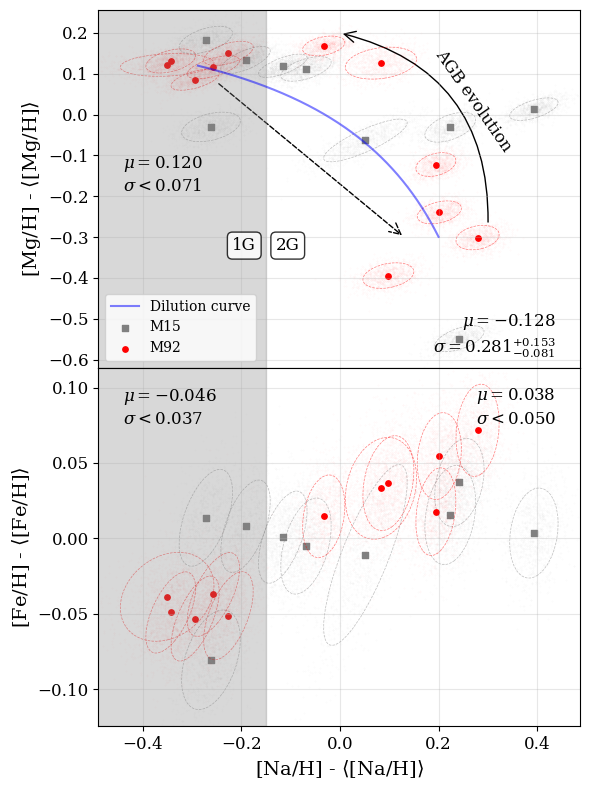

Plot saved to Na__Sr_Y_Zr.png


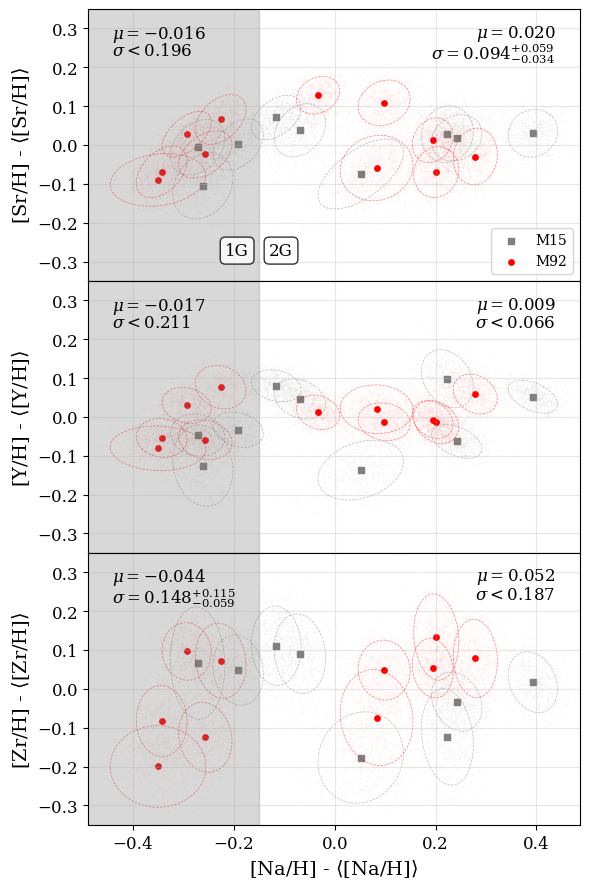

Plot saved to Na__Ba_La_Eu.png


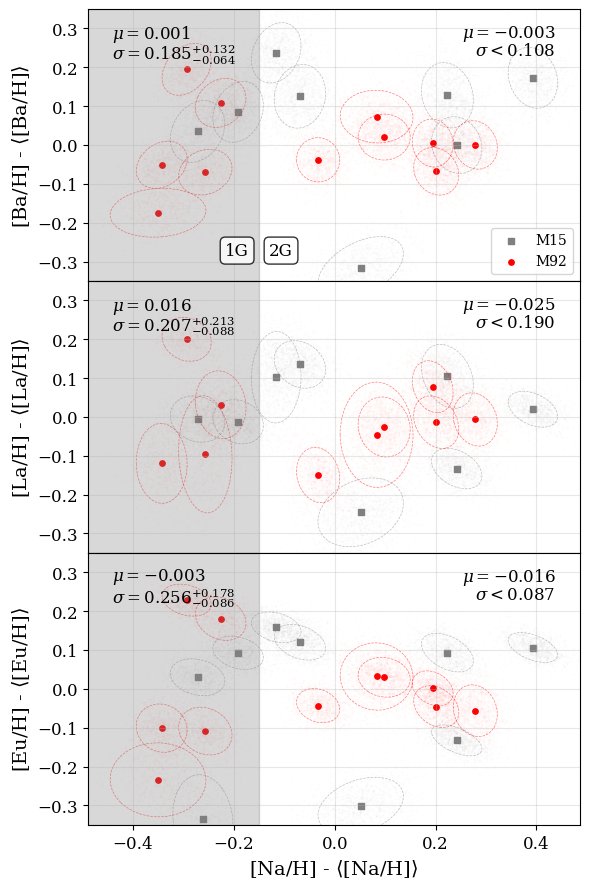


Supplementary figures:
Plot saved to Na__Mg_Al_Si_K.png


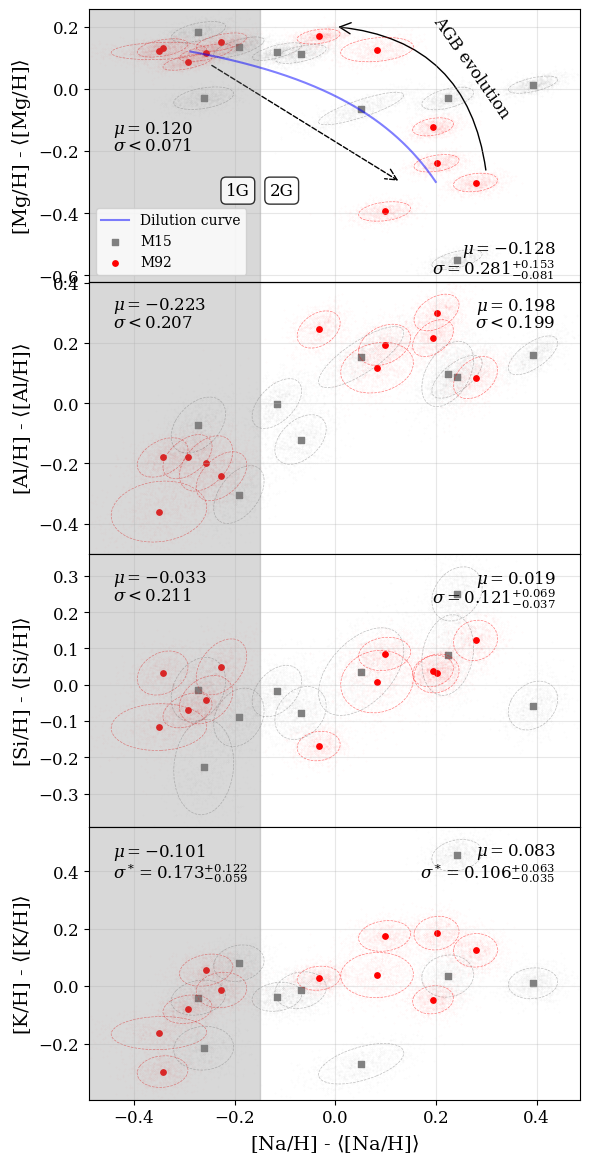

Plot saved to Mg__Na_Al_Si_K.png


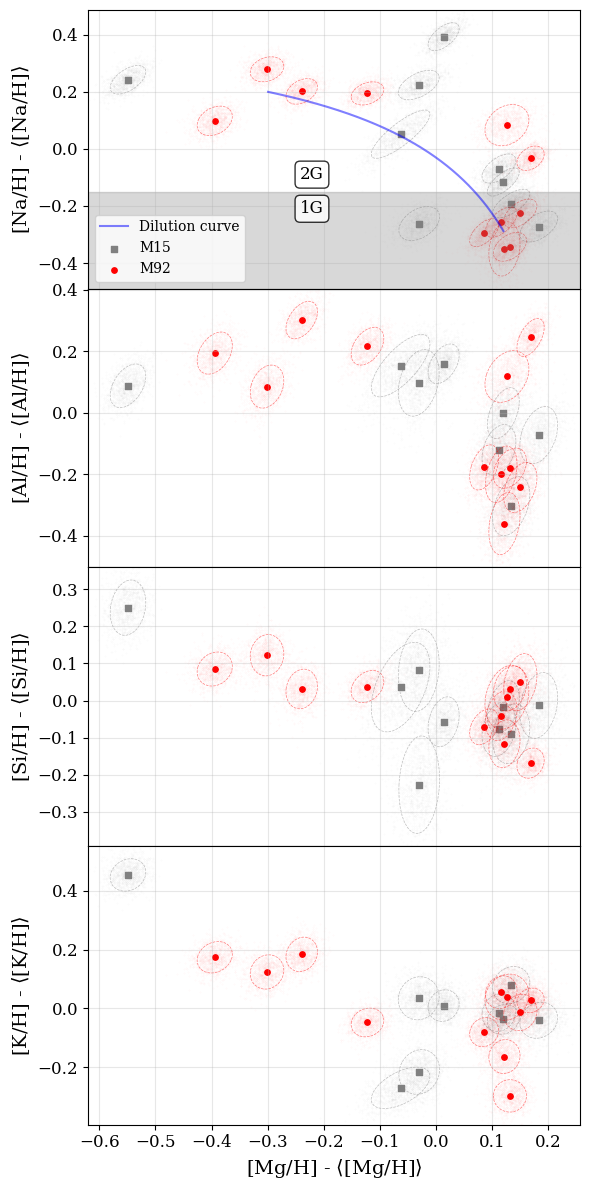

Plot saved to Na__Ca_Sc_Ti_V_Cr.png


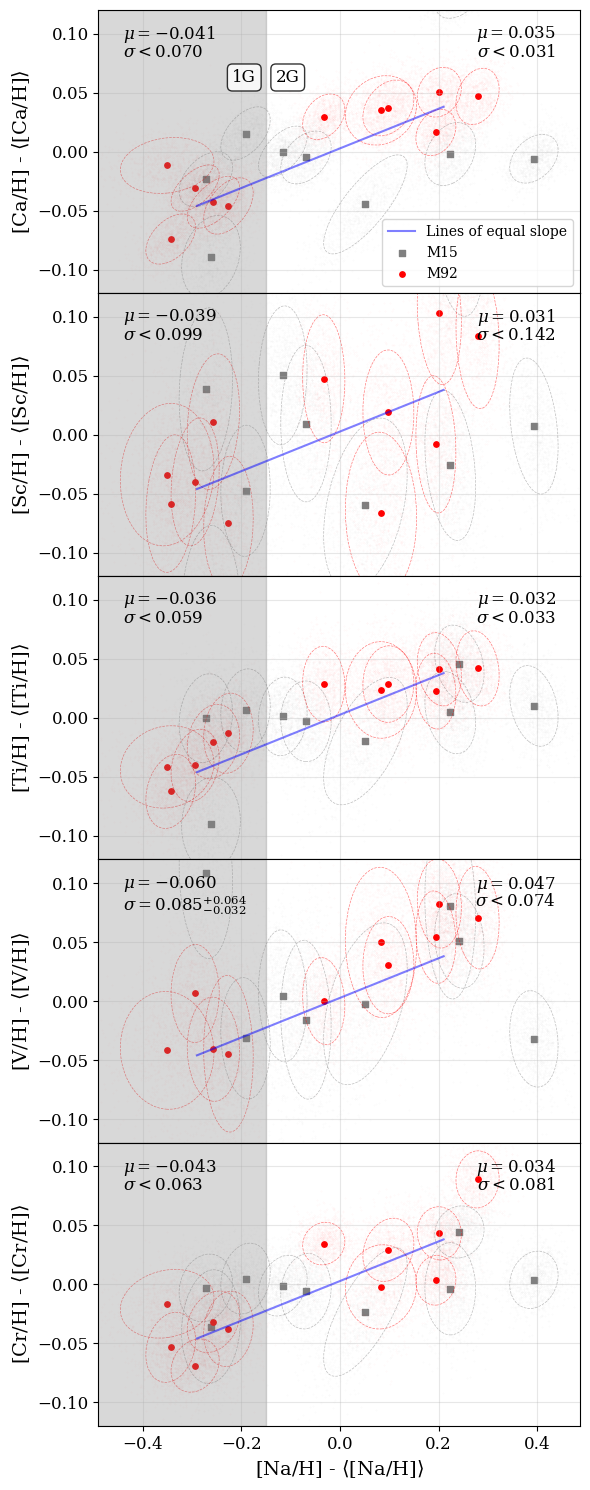

Plot saved to Na__Mn_Fe_Co_Ni_Zn.png


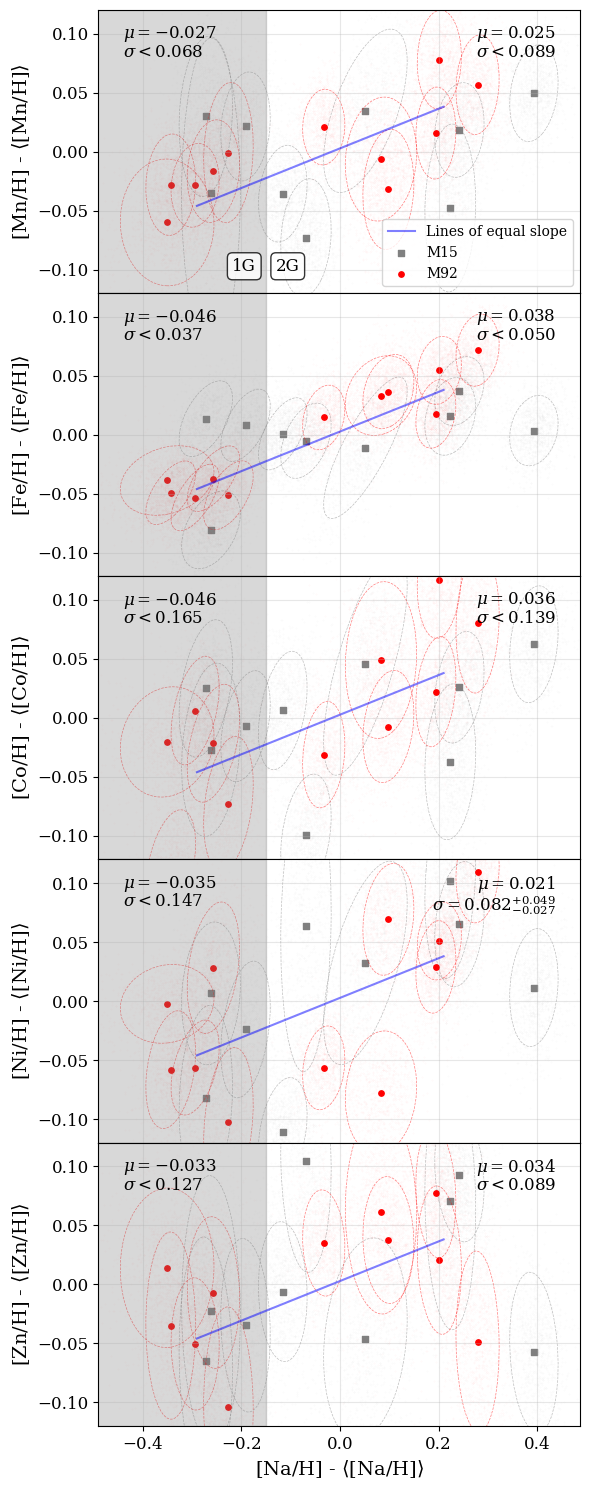

Plot saved to Na__Ba_Eu.png


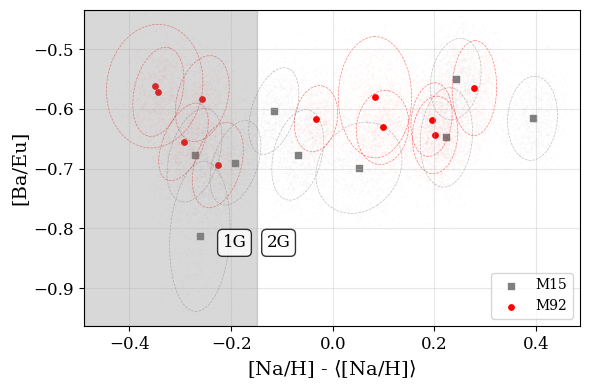


✓ All figures generated successfully!


In [17]:
# =============================================================================
# GENERATE PUBLICATION-QUALITY ABUNDANCE PLOTS
# =============================================================================
# Create multi-panel abundance correlation plots showing:
# - Error ellipses (68% confidence from MC trials)
# - 1G/2G population separation (shaded region at [Na/Fe] = -0.15)
# - Population statistics (mean ± scatter for each generation)
#
# Main text figures:
#   - Na vs. Mg, Fe: Classic multiple population signature
#   - Na vs. Sr, Y, Zr: Light s-process elements
#   - Na vs. Ba, La, Eu: Heavy s-process and r-process
#
# Supplementary figures:
#   - Additional element combinations for comprehensive element analysis

# Population split thresholds
na_pop_split = -0.15  # [Na/Fe] threshold: 1G (below) vs. 2G (above)
fe_pop_split = -0.015  # Alternative [Fe/H] split (not used in final analysis)

print("Generating publication figures...")
print(f"  Population split: [Na/Fe] = {na_pop_split}")

# ===== MAIN TEXT FIGURES =====
print("\nMain text figures:")
plot_abunddiff(avg_abunds, gcs=gcs, el1='Na', el2=['Mg', 'Fe'], 
               savefig='Na__Mg_Fe.png', gen_labels=True, shading=na_pop_split, showstats=True)

plot_abunddiff(avg_abunds, gcs=gcs, el1='Na', el2=['Sr', 'Y', 'Zr'], 
               savefig='Na__Sr_Y_Zr.png', shading=na_pop_split, ylim=[-0.35, 0.35], 
               gen_labels=True, showstats=True)

plot_abunddiff(avg_abunds, gcs=gcs, el1='Na', el2=['Ba', 'La', 'Eu'], 
               savefig='Na__Ba_La_Eu.png', shading=na_pop_split, ylim=[-0.35, 0.35], 
               gen_labels=True, showstats=True)

# ===== SUPPLEMENTARY FIGURES =====
print("\nSupplementary figures:")
plot_abunddiff(avg_abunds, gcs=gcs, el1='Na', el2=['Mg', 'Al', 'Si', 'K'], 
               savefig='Na__Mg_Al_Si_K.png', shading=na_pop_split, gen_labels=True, showstats=True)

plot_abunddiff(avg_abunds, gcs=gcs, el1='Mg', el2=['Na', 'Al', 'Si', 'K'], 
               savefig='Mg__Na_Al_Si_K.png', gen_labels=True)

plot_abunddiff(avg_abunds, gcs=gcs, el1='Na', el2=['Ca', 'Sc', 'Ti', 'V', 'Cr'], 
               savefig='Na__Ca_Sc_Ti_V_Cr.png', shading=na_pop_split, ylim=[-0.12, 0.12], 
               gen_labels=True, showstats=True)

plot_abunddiff(avg_abunds, gcs=gcs, el1='Na', el2=['Mn', 'Fe', 'Co', 'Ni', 'Zn'], 
               savefig='Na__Mn_Fe_Co_Ni_Zn.png', shading=na_pop_split, ylim=[-0.12, 0.12], 
               gen_labels=True, showstats=True)

plot_abunddiff_ratio(avg_abunds, gcs=gcs, el1='Na', el2=[['Ba', 'Eu']], 
                     savefig='Na__Ba_Eu.png', shading=na_pop_split, gen_labels=True)

print("\n✓ All figures generated successfully!")


## 13. LaTeX Table Generation

Create formatted abundance tables for manuscript appendix.

In [18]:
import re

def natural_key(s):
    # Custom sort: M92 before M15, then natural sort for numbers
    s_lower = s.lower()
    if s_lower.startswith('m92'):
        prefix = 0
    elif s_lower.startswith('m15'):
        prefix = 1
    else:
        prefix = 2
    # Natural sort for the rest
    rest = [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]
    return [prefix] + rest

def make_latex_abundance_table(avg_abunds, star_names_full, precision=3, caption=None, label=None, filename='abundance_table.tex', elements_list=['Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Sr', 'Y', 'Zr', 'Ba', 'La', 'Nd', 'Eu', 'Dy']):
    """
    Output a LaTeX table of star names and their average abundances for all elements.
    avg_abunds: list of DataFrames (one per cluster)
    star_names_full: list of lists of star names (one per cluster)
    precision: number of decimal places
    caption: LaTeX caption string
    label: LaTeX label string
    """
    import numpy as np
    # Collect all unique star names and all unique elements
    all_star_names = []
    all_elements = set()
    star_to_abund = dict()
    star_to_abunderr = dict()
    for avg_abund, star_names in zip(avg_abunds, star_names_full):
        for idx, name in enumerate(star_names):
            all_star_names.append(name)
            for _, row in avg_abund.iterrows():
                element = row['element']
                all_elements.add(element)
                abunds = row['abunddiff']
                abunderrs = row['abunddifferr']
                if name not in star_to_abund:
                    star_to_abund[name] = dict()
                    star_to_abunderr[name] = dict()
                if idx < len(abunds):
                    star_to_abund[name][element] = abunds[idx]
                    star_to_abunderr[name][element] = abunderrs[idx]
                else:
                    star_to_abund[name][element] = np.nan
                    star_to_abunderr[name][element] = np.nan
    # Remove duplicates in star names, keep order
    seen = set()
    unique_star_names = []
    for name in all_star_names:
        if name not in seen:
            unique_star_names.append(name)
            seen.add(name)
    # Build LaTeX table
    unique_star_names = sorted(unique_star_names, key=natural_key)
    header = r"\begin{sidewaystable}\n"
    if caption:
        header += f"\\caption{{{caption}}}"
    if label:
        header += f"\\label{{{label}}}"
    header += "\n"
    header += r"\begin{tabular*}{\textheight}{@{\extracolsep\fill}l " + " ".join(["c"]*len(elements_list)) + r"@{}}\n"
    header += r"\toprule\n"
    header += "Star"
    for el in elements_list:
        header += f" & {el}"
    header += r" \\ \midrule\n"
    body = ""
    for name in unique_star_names:
        body += name
        for el in elements_list:
            abund = star_to_abund.get(name, {}).get(el, np.nan)
            abunderr = star_to_abunderr.get(name, {}).get(el, np.nan)
            abund_str = f"${abund:+.{precision}f} \\pm {abunderr:.{precision}f}$" if np.isfinite(abund) else "---"
            body += f" & {abund_str}"
        body += r" \\ \n"
    footer = r"\botrule\n\end{tabular*}\n"
    footer += r"\end{sidewaystable}"
    latex_table = header + body + footer
    with open(filename, 'w') as f:
        f.write(latex_table.replace("\\n", "\n"))
    return latex_table.replace("\\n", "\n")


def make_latex_average_abund_table():
    cat = get_catalog()
    avg_abunds = []
    star_names_full = []
    for cluster in cat:
        avg_abunds.append(cluster['avg_abund'])
        star_names_full.append(cluster['star_names'])
        
        
make_latex_abundance_table(avg_abunds, star_names_full, caption='Differential abundances for all stars.', label='tab:allabund')
make_latex_abundance_table(avg_abunds, star_names_full, filename='abundance_table1.tex', caption='Differential abundances for Na through Ti.', label='tab:abund1', elements_list=['Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti'])
make_latex_abundance_table(avg_abunds, star_names_full, filename='abundance_table2.tex', caption='Differential abundances for V through Sr.', label='tab:abund2', elements_list=['V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Zn', 'Sr'])
make_latex_abundance_table(avg_abunds, star_names_full, filename='abundance_table3.tex', caption='Differential abundances for Y through Dy.', label='tab:abund3', elements_list=['Y', 'Zr', 'Ba', 'La', 'Nd', 'Eu', 'Dy'])



'\\begin{sidewaystable}\n\\caption{Differential abundances for Y through Dy.}\\label{tab:abund3}\n\\begin{tabular*}{\\textheight}{@{\\extracolsep\\fill}l c c c c c c c@{}}\n\\toprule\nStar & Y & Zr & Ba & La & Nd & Eu & Dy \\\\ \\midrule\nM92-star-1 & $-0.081 \\pm 0.038$ & $-0.200 \\pm 0.069$ & $-0.174 \\pm 0.041$ & --- & --- & $-0.234 \\pm 0.063$ & --- \\\\ \nM92-star-2 & $+0.059 \\pm 0.034$ & $+0.078 \\pm 0.067$ & $+0.000 \\pm 0.041$ & $-0.007 \\pm 0.045$ & --- & $-0.056 \\pm 0.044$ & $+0.061 \\pm 0.161$ \\\\ \nM92-star-3 & $-0.013 \\pm 0.037$ & $+0.133 \\pm 0.073$ & $-0.068 \\pm 0.040$ & $-0.014 \\pm 0.045$ & $-0.255 \\pm 0.073$ & $-0.046 \\pm 0.036$ & --- \\\\ \nM92-star-4 & $-0.007 \\pm 0.032$ & $+0.053 \\pm 0.050$ & $+0.005 \\pm 0.041$ & $+0.078 \\pm 0.044$ & $+0.028 \\pm 0.074$ & $+0.001 \\pm 0.030$ & --- \\\\ \nM92-star-6 & $+0.030 \\pm 0.031$ & $+0.096 \\pm 0.049$ & $+0.195 \\pm 0.044$ & $+0.200 \\pm 0.037$ & $+0.132 \\pm 0.058$ & $+0.228 \\pm 0.027$ & $+0.100 \\pm 0.075$ \\\\

In [19]:
def make_cluster_avgabund_latex_table(avg_abunds, gcs=['M15', 'M92'], precision=3, caption=None, label=None, filename='avgabund_table.tex'):
    """
    Output a LaTeX table with columns: element, M92 avgabund, M15 avgabund.
    avg_abunds: list of DataFrames, one per cluster, in the same order as gcs
    gcs: list of cluster names, order must match avg_abunds
    """
    import numpy as np
    # Collect all unique elements
    all_elements = set()
    for avg_abund in avg_abunds:
        all_elements.update(avg_abund['element'].tolist())
    elements_list = ['Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Zn', 'Sr', 'Y', 'Zr', 'Ba', 'La', 'Nd', 'Eu', 'Dy']
    # Build lookup for each cluster
    cluster_lookup = []
    for avg_abund in avg_abunds:
        lookup = {row['element']: row['avgabund'] for _, row in avg_abund.iterrows()}
        cluster_lookup.append(lookup)
    # Build LaTeX table
    header = r"\begin{table}[h!]\n"
    if caption:
        header += f"\\caption{{{caption}}}\label{{tab:avgabund}}"
    if label:
        header += f"\\label{{{label}}}"
    header += "\n"
    header += r"\begin{tabular}{lcc}\n"
    header += r"\toprule\n"
    header += "Element & " + " & ".join(gcs) + r" \\ \midrule\n"
    body = ""
    for el in elements_list:
        row = [el]
        for i in range(len(gcs)):
            val = cluster_lookup[i].get(el, np.nan)
            val_str = f"${val:+.{precision}f}$" if np.isfinite(val) else "---"
            row.append(val_str)
        body += " & ".join(row) + r" \\ \n"
    footer = r"\bottomrule\n\end{tabular}\n"
    footer += r"\end{table}"
    latex_table = header + body + footer
    with open(filename, 'w') as f:
        f.write(latex_table.replace("\\n", "\n"))
    return latex_table.replace("\\n", "\n")

make_cluster_avgabund_latex_table(avg_abunds, caption='Average abundances ($12 + \log n({\mathrm X})/n({\mathrm H}))$) in each cluster.')


<>:21: SyntaxWarning: invalid escape sequence '\l'
<>:43: SyntaxWarning: invalid escape sequence '\l'
<>:21: SyntaxWarning: invalid escape sequence '\l'
<>:43: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1452051/3242068711.py:21: SyntaxWarning: invalid escape sequence '\l'
  header += f"\\caption{{{caption}}}\label{{tab:avgabund}}"
/tmp/ipykernel_1452051/3242068711.py:43: SyntaxWarning: invalid escape sequence '\l'
  make_cluster_avgabund_latex_table(avg_abunds, caption='Average abundances ($12 + \log n({\mathrm X})/n({\mathrm H}))$) in each cluster.')


'\\begin{table}[h!]\n\\caption{Average abundances ($12 + \\log n({\\mathrm X})/n({\\mathrm H}))$) in each cluster.}\\label{tab:avgabund}\n\\begin{tabular}{lcc}\n\\toprule\nElement & M15 & M92 \\\\ \\midrule\nNa & $+4.472$ & $+4.242$ \\\\ \nMg & $+5.396$ & $+5.385$ \\\\ \nAl & $+4.016$ & $+3.980$ \\\\ \nSi & $+5.478$ & $+5.587$ \\\\ \nK & $+3.248$ & $+3.218$ \\\\ \nCa & $+4.208$ & $+4.233$ \\\\ \nSc & $+0.838$ & $+0.807$ \\\\ \nTi & $+2.833$ & $+2.839$ \\\\ \nV & $+1.618$ & $+1.682$ \\\\ \nCr & $+3.012$ & $+3.059$ \\\\ \nMn & $+2.483$ & $+2.538$ \\\\ \nFe & $+5.019$ & $+5.056$ \\\\ \nCo & $+2.698$ & $+2.729$ \\\\ \nNi & $+3.699$ & $+3.753$ \\\\ \nZn & $+2.278$ & $+2.271$ \\\\ \nSr & $+0.300$ & $+0.242$ \\\\ \nY & $-0.247$ & $-0.389$ \\\\ \nZr & $+0.433$ & $+0.370$ \\\\ \nBa & $-0.142$ & $-0.502$ \\\\ \nLa & $-0.778$ & $-1.136$ \\\\ \nNd & $-0.321$ & $-0.634$ \\\\ \nEu & $-1.120$ & $-1.540$ \\\\ \nDy & $-0.419$ & $-0.768$ \\\\ \n\\bottomrule\n\\end{tabular}\n\\end{table}'

In [20]:
from astropy.coordinates import Angle

def make_star_table(caption=None, label=None, filename='starlist_table.tex'):
    gaia = pd.concat([get_gaia('M92'), get_gaia(gc='M15')])
    gaia_coords = SkyCoord([sc for sc in gaia['skycoord']])
        
    cat = get_catalog()
    starstr = []
    for name in cat['NAME']:
        starstr.append(name.decode('utf-8'))
    starstr = [s for s in starstr if ((s.strip() != 'M92-star-5') & (s.strip() != 'M92-star-7'))]
    # Remove duplicates in star names, keep order
    seen = set()
    unique_star_names = []
    for name in starstr:
        if name not in seen:
            unique_star_names.append(name)
            seen.add(name)
    # Build LaTeX table
    unique_star_names = sorted(unique_star_names, key=natural_key)

    nm92 = len([name for name in unique_star_names if name.startswith('M92')])
    nm15 = len([name for name in unique_star_names if name.startswith('M15')])
    flatex.write(r"\newcommand{\nmone}{"+str(nm92)+"}\n")
    flatex.write(r"\newcommand{\nmtwo}{"+str(nm15)+"}\n")
    flatex.write(r"\newcommand{\nmtotal}{"+str(nm92+nm15)+"}\n")
    
    m92_mask = cat['NAME'].apply(lambda x: x.decode('utf-8').strip().startswith('M92'))
    m92_cat = cat[m92_mask]
    print(m92_mask)
    print(m92_cat['NAME'])
    print(m92_cat['teff'])
    print(m92_cat['teff'].max(), m92_cat['teff'].min())
    flatex.write(r"\newcommand{\teffrangeone}{"+str(int(m92_cat['teff'].max()-m92_cat['teff'].min()))+"}\n")
    flatex.write(r"\newcommand{\loggrangeone}{"+f"{m92_cat['logg'].max()-m92_cat['logg'].min():.2f}"+"}\n")
    flatex.write(r"\newcommand{\vtrangeone}{"+f"{m92_cat['vt'].max()-m92_cat['vt'].min():.2f}"+"}\n")

    m15_mask = cat['NAME'].apply(lambda x: x.decode('utf-8').strip().startswith('M15'))
    m15_cat = cat[m15_mask]
    flatex.write(r"\newcommand{\teffrangetwo}{"+str(int(m15_cat['teff'].max()-m15_cat['teff'].min()))+"}\n")
    flatex.write(r"\newcommand{\loggrangetwo}{"+f"{m15_cat['logg'].max()-m15_cat['logg'].min():.2f}"+"}\n")
    flatex.write(r"\newcommand{\vtrangetwo}{"+f"{m15_cat['vt'].max()-m15_cat['vt'].min():.2f}"+"}\n")

    flatex.write(r"\newcommand{\teffrangemax}{"+str(int(np.maximum(m92_cat['teff'].max()-m92_cat['teff'].min(), m15_cat['teff'].max()-m15_cat['teff'].min())))+"}\n")
    flatex.write(r"\newcommand{\loggrangemax}{"+f"{np.maximum(m92_cat['logg'].max()-m92_cat['logg'].min(), m15_cat['logg'].max()-m15_cat['logg'].min()):.2f}"+"}\n")
    flatex.write(r"\newcommand{\vtrangemax}{"+f"{np.maximum(m92_cat['vt'].max()-m92_cat['vt'].min(), m15_cat['vt'].max()-m15_cat['vt'].min()):.2f}"+"}\n")

    header = r"\begin{sidewaystable}\n"
    if caption:
        header += f"\\caption{{{caption}}}"
    if label:
        header += f"\\label{{{label}}}"
    header += "\n"
    header += r"\begin{tabular}{llccccccc}\n"
    header += r"\toprule\n"
    header += r"{\it Gaia} DR3 ID & Nickname & RA & Dec & $G$ & $G_{BP} - G_{RP}$ & $T_{\rm eff}$ (K)\footnotemark[1] & $\log g$ (cm s$^{-2}$) & $\xi$ (km s$^{-1}$) \\ \midrule\n"
    body = ""
    for star in unique_star_names:
        cat_row = cat[cat['NAME'] == star.encode('utf-8')]
        idx, d2d, d3d = SkyCoord(cat_row.iloc[0]['skycoord']).match_to_catalog_sky(gaia_coords)
        rastr = Angle(cat_row['RA'].values[0] * u.deg).to_string(unit='hourangle', sep='hms', precision=2, pad=True)
        decstr = Angle(cat_row['DEC'].values[0] * u.deg).to_string(unit='deg', sep='dms', precision=2, pad=True, alwayssign=True)
        gaiaidstr = f"{gaia.iloc[idx]['source_id']}"
        gstr = f"{gaia.iloc[idx]['phot_g_mean_mag']:.4f}"
        bprpstr = f"{(gaia.iloc[idx]['phot_bp_mean_mag'] - gaia.iloc[idx]['phot_rp_mean_mag']):.4f}"
        teffstr = f"{cat_row['teff'].values[0]:0.0f}"
        tefferrstr = f"{np.sqrt(cat_row['tefferr'].values[0]**2 - 83**2):0.0f}"
        loggstr = f"{cat_row['logg'].values[0]:.2f}"
        loggerrstr = f"{cat_row['loggerr'].values[0]:.2f}"
        vtstr = f"{cat_row['vt'].values[0]:.2f}"
        vterrstr = f"{cat_row['vterr'].values[0]:.2f}"
        val_str = f"{gaiaidstr} & {star} & {rastr} & {decstr} & {gstr} & {bprpstr} & ${teffstr} \pm {tefferrstr}$ & ${loggstr} \pm {loggerrstr}$ & ${vtstr} \pm {vterrstr}$"
        body += val_str + r" \\ \n"
    footer = r"\bottomrule\n\end{tabular}\n"
    footer += r"\footnotetext[1]{The uncertainty is the random component propagated from the $G_{BP}-G_{RP}$ color.  The color--$T_{\rm eff}$ relation\citep{muc21} gives an additional systematic uncertainty of 83~K\@.  The Methods section discusses our separate treatment of these errors.}"
    footer += r"\end{sidewaystable}"
    latex_table = header + body + footer
    with open(filename, 'w') as f:
        f.write(latex_table.replace("\\n", "\n"))
    return

make_star_table(caption='Star coordinates and atmospheric parameters.', label='tab:starcoords', filename='starlist_table.tex')

<>:72: SyntaxWarning: invalid escape sequence '\p'
<>:72: SyntaxWarning: invalid escape sequence '\p'
<>:72: SyntaxWarning: invalid escape sequence '\p'
<>:72: SyntaxWarning: invalid escape sequence '\p'
<>:72: SyntaxWarning: invalid escape sequence '\p'
<>:72: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_1452051/4261553707.py:72: SyntaxWarning: invalid escape sequence '\p'
  val_str = f"{gaiaidstr} & {star} & {rastr} & {decstr} & {gstr} & {bprpstr} & ${teffstr} \pm {tefferrstr}$ & ${loggstr} \pm {loggerrstr}$ & ${vtstr} \pm {vterrstr}$"
/tmp/ipykernel_1452051/4261553707.py:72: SyntaxWarning: invalid escape sequence '\p'
  val_str = f"{gaiaidstr} & {star} & {rastr} & {decstr} & {gstr} & {bprpstr} & ${teffstr} \pm {tefferrstr}$ & ${loggstr} \pm {loggerrstr}$ & ${vtstr} \pm {vterrstr}$"
/tmp/ipykernel_1452051/4261553707.py:72: SyntaxWarning: invalid escape sequence '\p'
  val_str = f"{gaiaidstr} & {star} & {rastr} & {decstr} & {gstr} & {bprpstr} & ${teffstr} \pm {tefferrstr

0      True
1     False
2     False
3     False
4      True
5      True
6      True
7     False
8      True
9      True
10    False
11    False
12     True
13     True
14     True
15    False
16    False
17     True
18     True
19     True
20    False
Name: NAME, dtype: bool
0     b'M92-star-12'
4     b'M92-star-6 '
5     b'M92-star-4 '
6     b'M92-star-11'
8     b'M92-star-5 '
9     b'M92-star-1 '
12    b'M92-star-9 '
13    b'M92-star-13'
14    b'M92-star-8 '
17    b'M92-star-10'
18    b'M92-star-2 '
19    b'M92-star-3 '
Name: NAME, dtype: object
0     5026.985394
4     5014.983542
5     5013.551421
6     5024.478534
8             NaN
9     5001.093113
12    5011.564117
13    5017.234345
14    4984.551514
17    5016.099838
18    5006.068973
19    5012.225689
Name: teff, dtype: float64
5026.985394013106 4984.551513825633


## 14. Color-Magnitude Diagram Generation

Create CMDs showing target stars in context of full cluster populations from Gaia DR3.

/tmp/ipykernel_1452051/2596270158.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


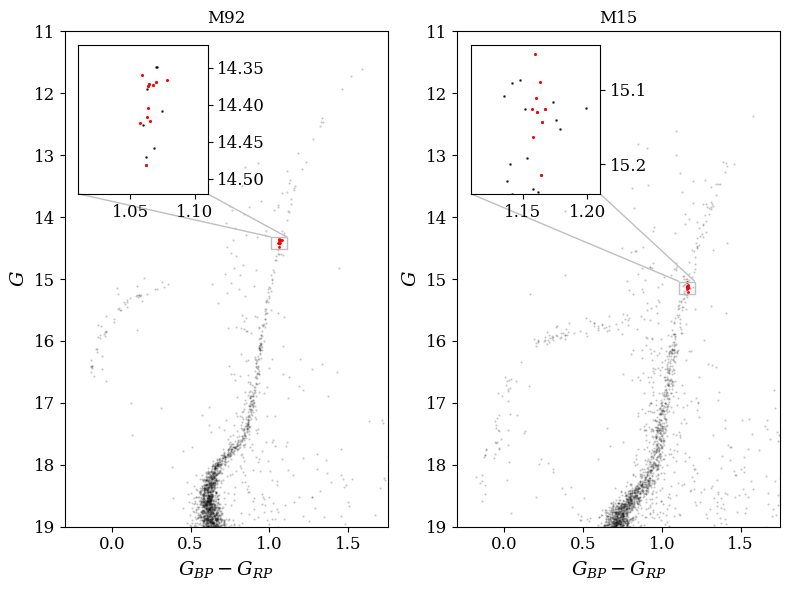

In [21]:

def make_cmd():
    gcs = ['M92', 'M15']
    cat = get_catalog()
    starstr = []
    for name in cat['NAME']:
        starstr.append(name.decode('utf-8').strip())
    cat_coords = SkyCoord([sc for (sc, name) in zip(cat['skycoord'], starstr) if ((name != 'M92-star-5') & (name != 'M92-star-7'))])
    starstr = [s for s in starstr if ((s != 'M92-star-5') & (s != 'M92-star-7'))]
    fig = plt.figure(figsize=(8, 6))
    axs = [fig.add_subplot(121), fig.add_subplot(122)]
    for i, gc in enumerate(gcs):
        catgc = [s.startswith(gc) for s in starstr]
        gaia = get_gaia(gc=gc)
        
        gaia_coords = SkyCoord([sc for sc in gaia['skycoord']])
        meanra = np.mean(gaia['ra'])
        meandec = np.mean(gaia['dec'])
        mean_coords = SkyCoord(ra=meanra, dec=meandec, unit='deg')
        sep = gaia_coords.separation(mean_coords)
        pm = np.sqrt(gaia['pmra']**2 + gaia['pmdec']**2)
        meanpm = np.nanmean(pm)
        mask = (sep > 3*u.arcmin) & (abs(pm-meanpm) < 2.0)
        idx, d2d, d3d = cat_coords[catgc].match_to_catalog_sky(gaia_coords)
        
        # Main CMD panel
        axs[i].scatter(gaia[mask]['phot_bp_mean_mag']-gaia[mask]['phot_rp_mean_mag'], gaia[mask]['phot_g_mean_mag'], s=0.3, alpha=0.2, color='k')
        axs[i].set_xlabel(r'$G_{BP} - G_{RP}$')
        axs[i].set_ylabel(r'$G$')
        axs[i].set_title(f'{gc}')
        axs[i].scatter(gaia.iloc[idx]['phot_bp_mean_mag']-gaia.iloc[idx]['phot_rp_mean_mag'], gaia.iloc[idx]['phot_g_mean_mag'], s=1,color='red')
        axs[i].set_xlim(-0.3, 1.75)
        axs[i].set_ylim(19, 11)
        
        # Add inset axes for zoom-in region
        axins = inset_axes(axs[i], width="40%", height="30%", loc='upper left', borderpad=1)
        # Define zoom region (customize as needed)
        if gc == 'M92':
            x1, x2 = 1.01, 1.11  # BP-RP range for zoom
            y1, y2 = 14.52, 14.32    # G mag range for zoom (brighter is lower)
        elif gc == 'M15':
            x1, x2 = 1.11, 1.21  # BP-RP range for zoom
            y1, y2 = 15.24, 15.04    # G mag range for zoom (brighter is lower)
        else:
            raise NotImplementedError("Zoom region not defined for this cluster.")
            
        axins.scatter(gaia[mask]['phot_bp_mean_mag']-gaia[mask]['phot_rp_mean_mag'], gaia[mask]['phot_g_mean_mag'], s=0.8, alpha=0.7, color='k')
        axins.scatter(gaia.iloc[idx]['phot_bp_mean_mag']-gaia.iloc[idx]['phot_rp_mean_mag'], gaia.iloc[idx]['phot_g_mean_mag'], s=1.5,color='red')
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
        #axins.set_xticks([])
        #axins.set_yticks([])
        axins.yaxis.tick_right()
        axins.yaxis.set_label_position('right')
        # Draw a box on the main panel to show the zoomed region
        mark_inset(axs[i], axins, loc1=3, loc2=4, fc="none", ec="0.75")
    plt.tight_layout()
    plt.savefig("m92_m15_cmd.png", dpi=300)

make_cmd()

## 15. Spectral Line Visualization

Functions for plotting normalized spectra showing key diagnostic lines for multiple stars.

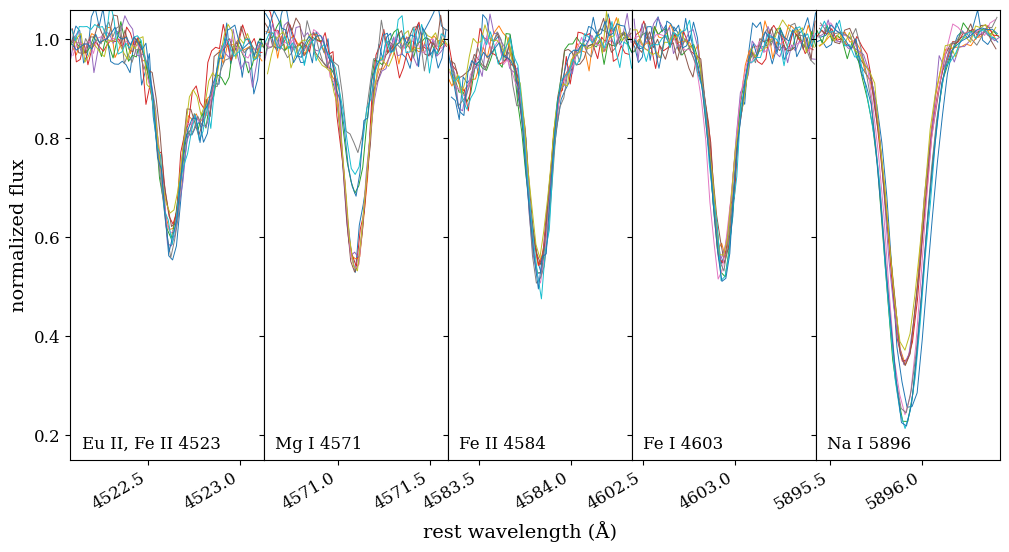

In [22]:
c = 2.99792458e5

def vacuum_to_air(wl_vac):
    """Convert vacuum wavelengths (in Angstroms) to air wavelengths (in Angstroms) using the standard formula."""
    # Ciddor 1996 formula (recommended for high-precision work)
    s = 1e4 / wl_vac  # inverse microns
    n = 1 + 0.0000834254 + 0.02406147 / (130.106592 - s**2) + 0.00015998 / (38.92568793 - s**2)
    wl_air = wl_vac * n
    return wl_air

def read_spectrum(star, vr=0):
    fname = 'spectra/'+star+'.fits.gz'
    with fits.open(fname) as hdul:
        data = hdul[1].data
        #header = hdul[1].header
        wl_vac = data['lambda'] / (1 + vr / c)
        wl_air = vacuum_to_air(wl_vac)
        flux = data['spec']
        ivar = data['ivar']
    return {'wl':wl_air, 'flux':flux, 'ivar':ivar}

def make_spectra_figure():
    import matplotlib.gridspec as gridspec
    from matplotlib.ticker import ScalarFormatter
    gcs = ['M92']
    cat = get_catalog()
    starstr = []
    for name in cat['NAME']:
        starstr.append(name.decode('utf-8'))
    
    #waves = [(4129.208, 4130.208), (4570.596, 4571.596), (4583.329, 4584.329), (5895.424, 5896.424)]
    #labels = ['Eu II 4129.708', 'Mg I 4571.096', 'Fe II 4583.829', 'Na I 5895.924']
    waves = [(4522.073, 4523.128), (4570.596, 4571.596), (4583.329, 4584.329), (4602.441, 4603.441), (5895.424, 5896.424)]
    labels = ['Eu II, Fe II 4523', 'Mg I 4571', 'Fe II 4584', 'Fe I 4603', 'Na I 5896']
    nwaves = len(waves)
    # Calculate width ratios based on xlim range
    width_ratios = [w[1] - w[0] for w in waves]

    for gc in gcs:
        stargc = [s for s in starstr if s.startswith(gc)]
        
        fig = plt.figure(figsize=(12, 6))
        gs = gridspec.GridSpec(1, nwaves, width_ratios=width_ratios, wspace=0)
        axs = [fig.add_subplot(gs[0, j]) for j in range(nwaves)]
        for j in range(nwaves):
            axs[j].set_xlim(waves[j])
            axs[j].set_ylim(0.15, 1.06)
            if j != 0:
                axs[j].set_yticklabels([])
                axs[j].set_ylabel("")
            else:
                axs[j].set_ylabel("normalized flux")
            # Show full value of each tick in the x-axis
            axs[j].xaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=False))
            axs[j].ticklabel_format(style='plain', axis='x')
        for i, star in enumerate(stargc):
            if (star.strip() == 'M92-star-5') | (star.strip() == 'M92-star-7'):
                continue
            cat_row = cat[cat['NAME'] == star.encode('utf-8')]
            spec = read_spectrum(star.strip(), vr = cat_row['VR'].values[0])
            for j in range(nwaves):
                w = (spec['wl'] > waves[j][0]) & (spec['wl'] < waves[j][1])
                axs[j].plot(spec['wl'][w], spec['flux'][w], label=star, linewidth=0.7)
                if i==0:
                    axs[j].text(0.06, 0.025, labels[j], transform=axs[j].transAxes, fontsize=12, fontweight='normal')
        fig.text(0.5, 0.01, 'rest wavelength (Å)', ha='center', va='center', fontsize=14, wrap=True)
        fig.subplots_adjust(bottom=0.13)  # Increase space above x-axis label
        # Prevent x-axis label overlap
        for ax in axs:
            for label in ax.get_xticklabels():
                label.set_rotation(30)
                label.set_horizontalalignment('right')
        # Hide the leftmost tick of the second subplot
        # if len(axs) > 1:
        #     xticklabels = axs[1].get_xticklabels()
        #     if len(xticklabels) > 0:
        #         xticklabels[1].set_visible(False)
        plt.savefig(gc+'_spectra.png', bbox_inches='tight')

make_spectra_figure()

## 16. Finalize LaTeX Output

Close the LaTeX macro definition file for manuscript preparation.

In [23]:
flatex.close()

---

# SUMMARY

## Workflow Overview

This notebook implements a complete high-resolution spectroscopic abundance analysis pipeline for M15 and M92 globular cluster red giant stars observed with Keck HIRES.

## Key Steps

1. **Data Loading**: Combined Gaia DR3 photometry with HIRES spectroscopic measurements
2. **Catalog Creation**: Merged astrometry, photometry, and stellar parameters
3. **Line-by-Line Analysis**: Combined ~100-300 spectral lines per element across multiple stars
4. **Differential Abundances**: Removed systematic offsets using star-to-star differences
5. **Weighted Averaging**: Combined multiple lines using inverse-variance weighting with 3σ outlier rejection
6. **Monte Carlo Error Propagation**: 1000 MC trials sampling Teff, logg, [Fe/H], vt errors
7. **Population Analysis**: Split into 1G/2G using [Na/Fe] and derived intrinsic scatter via MCMC
8. **Visualization**: Created publication-quality plots with 68% confidence ellipses

## Primary Data Products

- **avg_abund.pkl**: Final abundance catalog for 12 stars in M15 and M92
  - Photometric and spectroscopic stellar parameters
  - Elemental abundances [X/Fe] for 21+ elements (Na through Eu)
  - MC-derived uncertainties with full error correlations
  
- **M15_M92_macros.tex**: LaTeX macros with 1G/2G population statistics
  - Mean abundances and intrinsic scatter for each element
  - Significance tests for scatter (likelihood ratio)
  - Ready for direct inclusion in manuscript

- **Publication Figures**: PNG plots showing abundance correlations
  - Na-Mg anticorrelation (multiple populations signature)
  - Light elements (Na, Mg, Al) variations
  - Heavy elements (Sr, Y, Zr, Ba, La, Eu) vs. Na

## Scientific Results

- **Multiple Populations Identified**: Clear 1G (Na-poor) and 2G (Na-rich) separation
- **Na-Mg Anticorrelation**: Consistent with AGB self-enrichment scenario
- **Heavy Element Homogeneity**: No significant n-capture variations between 1G/2G
- **Intrinsic Scatter**: Detected in light elements, absent in heavy elements

## Next Steps

The output file `avg_abund.pkl` feeds into `m15_m92_atlas.py` for:
- Generation of ATLAS9 model atmospheres
- Perturbed models for sensitivity analysis
- Spectral synthesis for detailed abundance measurements

## References

- **Gaia DR3**: Astrometry and photometry
- **Keck HIRES**: R~45,000 spectroscopy (3800-8000 Å)
- **MOOG**: LTE spectroscopic analysis
- **emcee**: MCMC Bayesian inference
- **AstroML**: Gaussian-Gaussian likelihood framework

---

**Analysis complete.** All abundance data, statistics, figures, and LaTeX tables have been generated.